# Cross-Country Comparisons

In [1]:
library(LalRUtils)
libreq(data.table, tidyverse, sf, janitor, anytime, lubridate, plotly, zoo, patchwork, ggrepel)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 20, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "tidyverse"  TRUE  
 [3,] "sf"         TRUE  
 [4,] "janitor"    TRUE  
 [5,] "anytime"    TRUE  
 [6,] "lubridate"  TRUE  
 [7,] "plotly"     TRUE  
 [8,] "zoo"        TRUE  
 [9,] "patchwork"  TRUE  
[10,] "ggrepel"    TRUE  


# JHU

In [2]:
jhu_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
cases = fread(jhu_cases_url)

jhu_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths = fread(jhu_deaths_url)

In [3]:
name_clean = function(df) setnames(df, str_replace(colnames(df), "/", "_"))

In [4]:
cases_long = melt(cases, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "cases") 
name_clean(cases_long)

deaths_long = melt(deaths, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "deaths") 
name_clean(deaths_long)
deaths_long[, c('Lat', 'Long') := NULL]

In [5]:
df = merge(cases_long, deaths_long,
      by = c("Province_State", "Country_Region", "date"), all.x = T)
df[, date := mdy(date)]
df[, day := weekdays(date)]
df[is.na(df)] = 0
df %>% glimpse

Rows: 34,846
Columns: 8
$ Province_State <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ Country_Region <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanis…
$ date           <date> 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-…
$ Lat            <dbl> 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33…
$ Long           <dbl> 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65…
$ cases          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ day            <chr> "Wednesday", "Thursday", "Friday", "Saturday", "Sunday…


In [6]:
fwrite(df, "data/jhu_panel.csv")

## Country Level

In [7]:
country_ts = df[, lapply(.SD, sum) , by = .(Country_Region, date), .SDcols = c("cases", "deaths")]

In [8]:
(t10countries = country_ts[date == max(country_ts$date)][order(-cases)][1:10])

Country_Region date       cases   deaths
1  US             2020-05-31 1790172 104381
2  Brazil         2020-05-31  514849  29314
3  Russia         2020-05-31  405843   4693
4  United Kingdom 2020-05-31  276156  38571
5  Spain          2020-05-31  239479  27127
6  Italy          2020-05-31  232997  33415
7  India          2020-05-31  190609   5408
8  France         2020-05-31  189009  28805
9  Germany        2020-05-31  183410   8540
10 Peru           2020-05-31  164476   4506

In [9]:
t10_subset = country_ts[Country_Region %in% t10countries$Country_Region]
setorder(t10_subset, Country_Region, date)
# normalise time from first day with >= 10 cases
t10_subset[cases >= 10,  c_time := seq_len(.N), by = .(Country_Region)]
t10_subset[deaths >= 1, d_time := seq_len(.N), by = .(Country_Region)]

In [10]:
setorder(t10_subset, Country_Region, date)
t10_subset[, new_cases  := cases - shift(cases), by = .(Country_Region)]
t10_subset[, new_deaths := deaths - shift(deaths), by = .(Country_Region)]
t10_subset[, cfr := deaths/cases]
smoothvars = c('cases', 'new_cases', 'deaths', 'new_deaths', 'cfr')
t10_subset[, paste0("rm7_", smoothvars) := lapply(.SD, rollmean, k = 7, fill = NA, na.pad = T), 
   by = .(Country_Region), .SDcols = smoothvars]

In [11]:
t10_subset[, label := ifelse(date == max(date), Country_Region, NA)]

## Cumulative and New Cases / Deaths 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 316 rows containing missing values (geom_point).”
Warning message:
“Removed 350 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 390 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 323 rows 

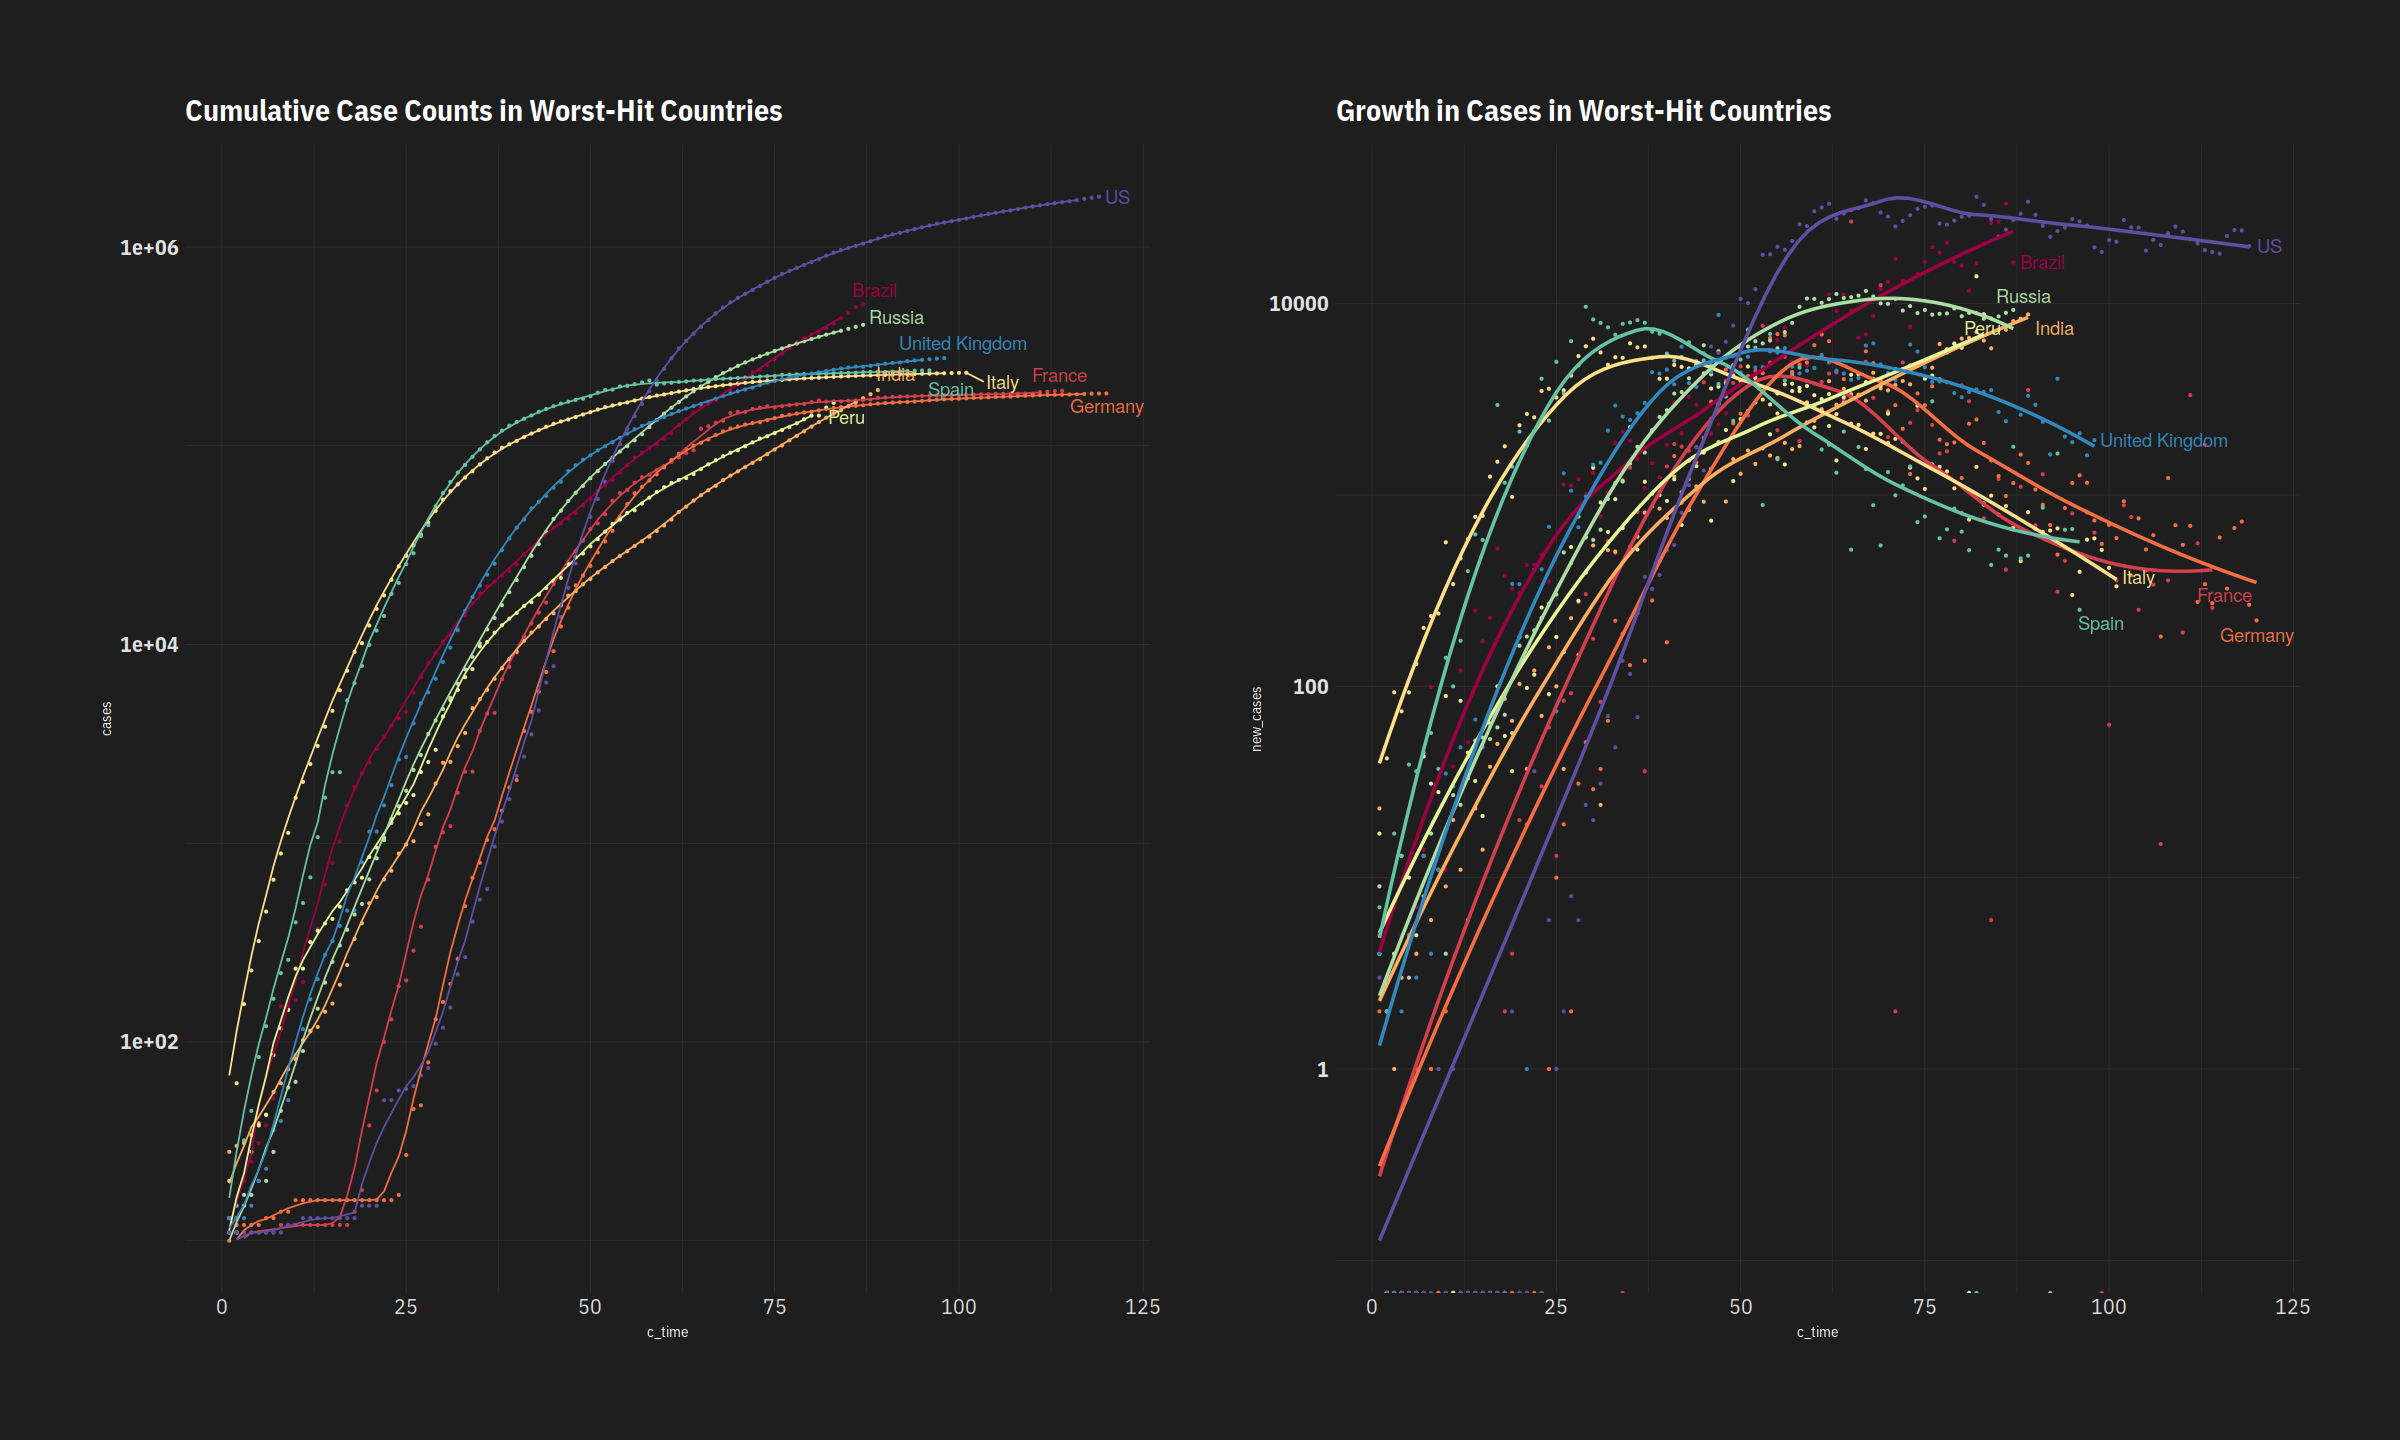

In [12]:
p1 = ggplot(t10_subset,
           aes(x = c_time, y = cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = cases), size = 0.5) + geom_line(aes(y = rm7_cases)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Case Counts in Worst-Hit Countries') 

p2 = 
    t10_subset %>% 
    ggplot(aes(x = c_time,y = new_cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_cases), size = 0.5) + 
#     geom_line(aes(y = rm7_new_cases)) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Cases in Worst-Hit Countries')

(p1 | p2 )

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 523 rows containing missing values (geom_point).”
Warning message:
“Removed 550 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 496 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 447 rows 

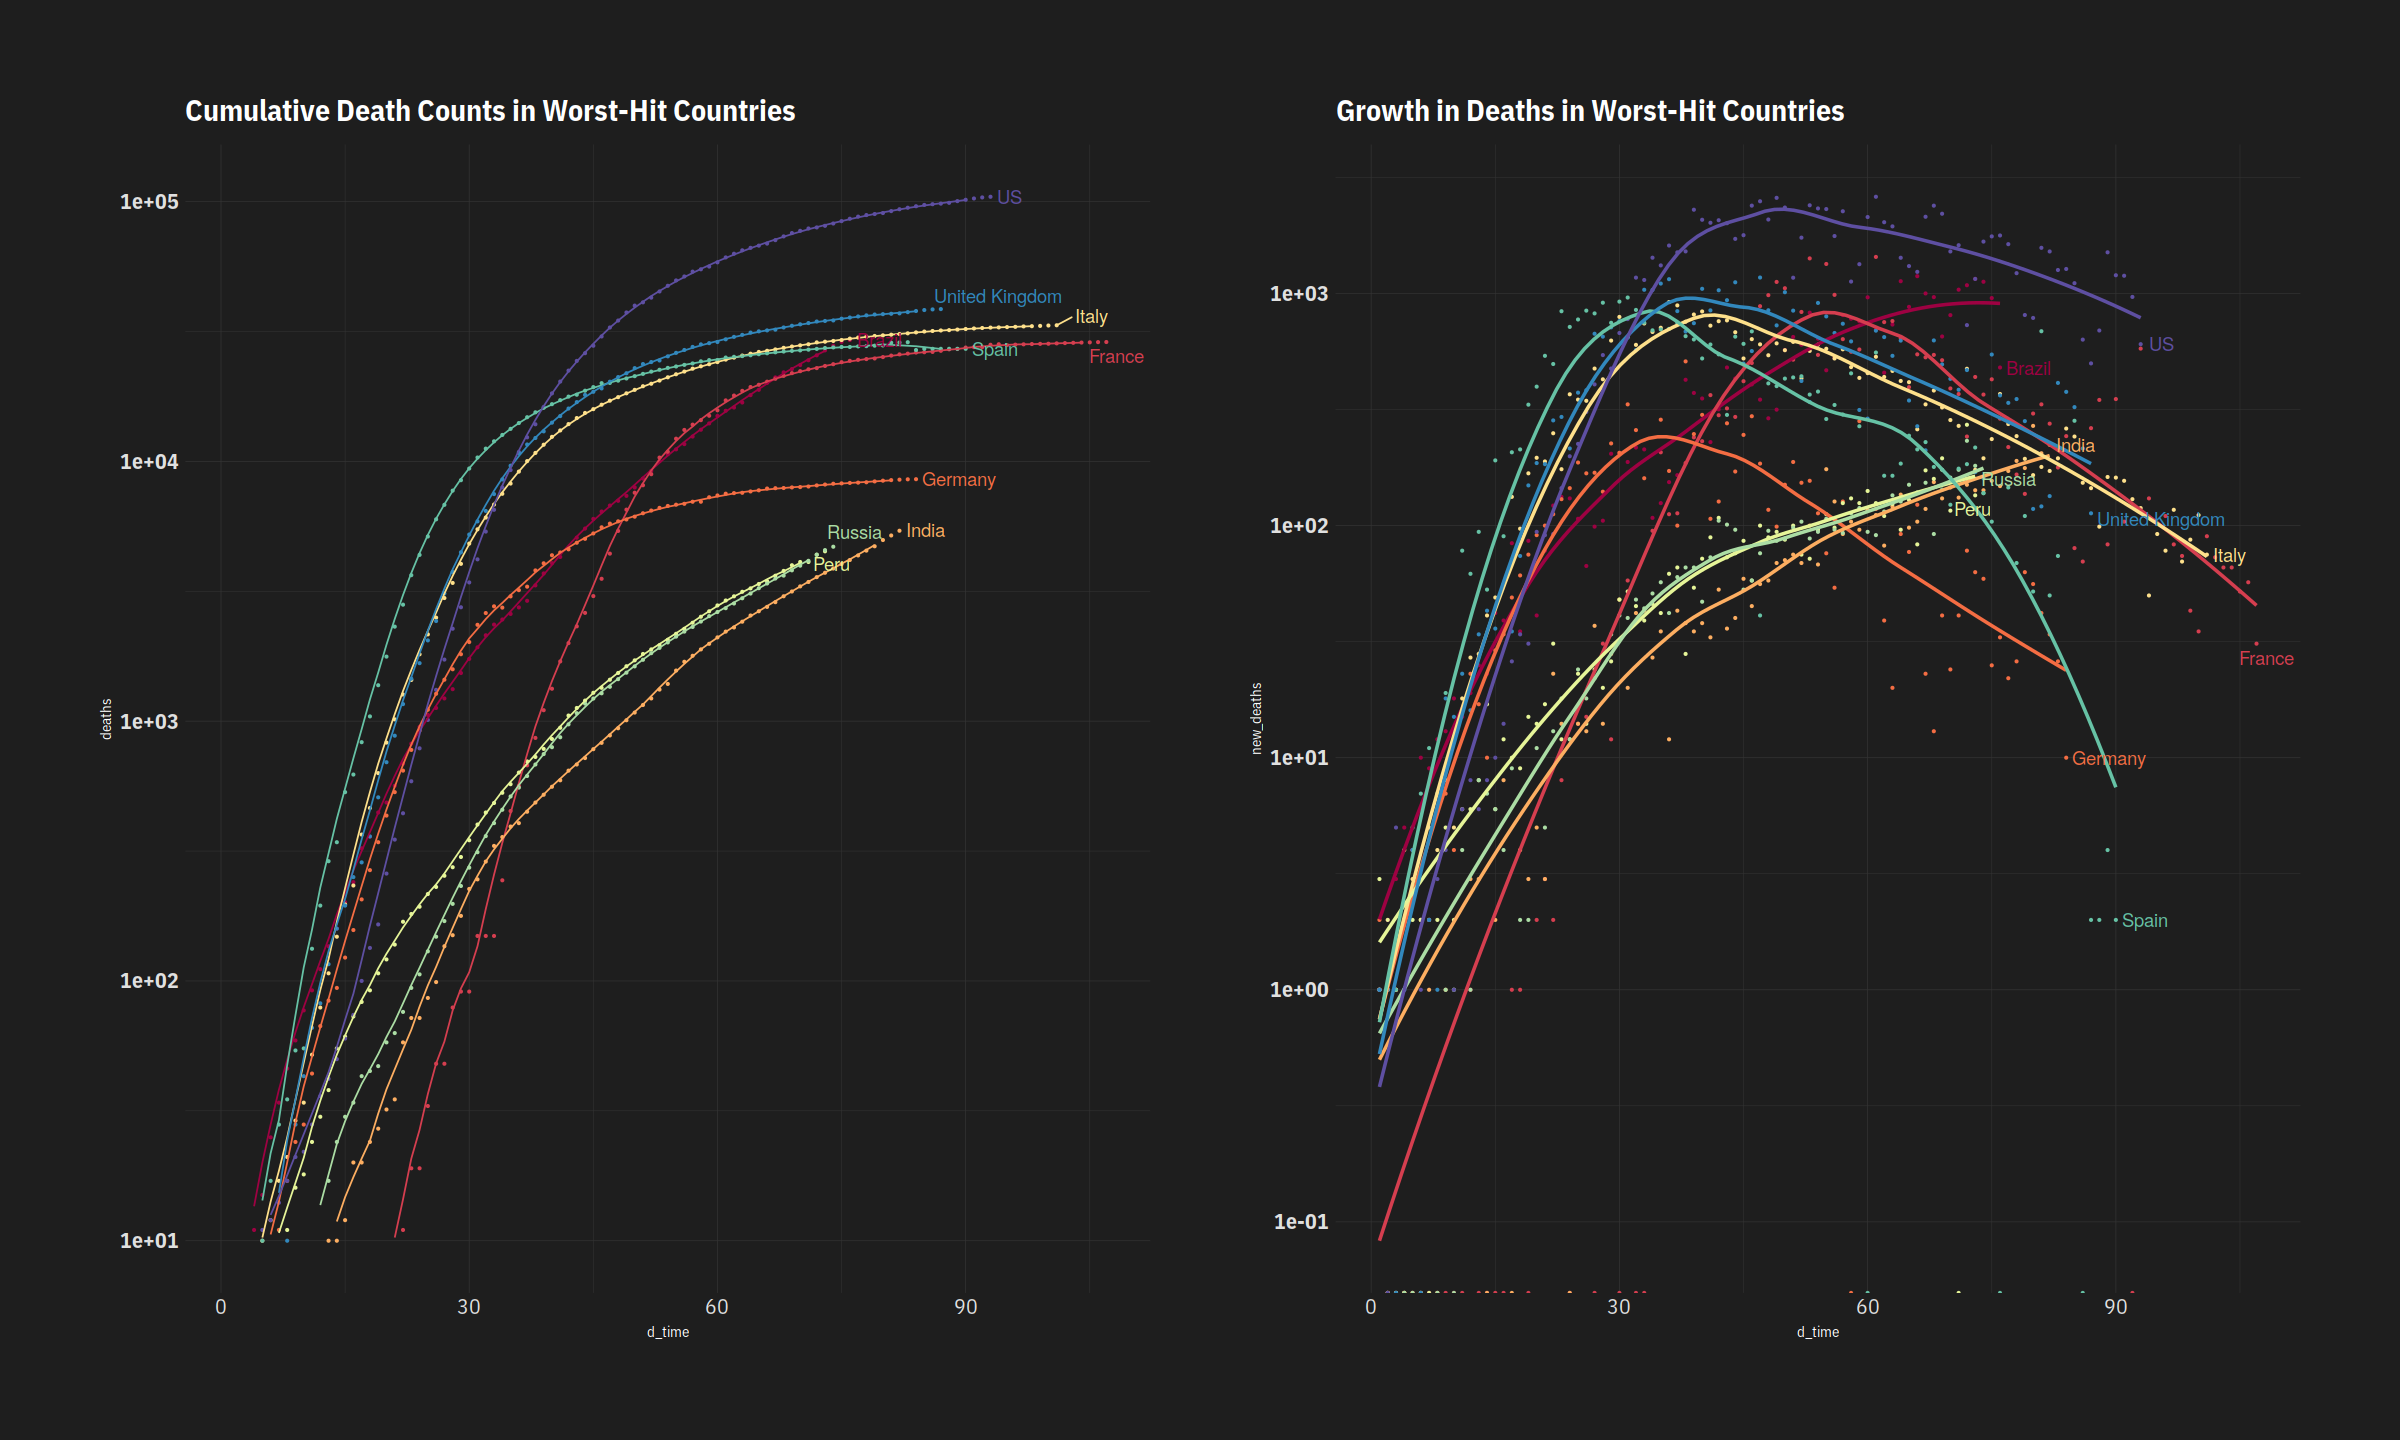

In [13]:
p1 = ggplot(t10_subset,
           aes(x = d_time, y = deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = deaths), size = 0.5) + geom_line(aes(y = rm7_deaths)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Death Counts in Worst-Hit Countries') 

p2 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = new_deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_deaths), size = 0.5) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Deaths in Worst-Hit Countries')

(p1 | p2 )

## Case Fatality Rate

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 443 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 443 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”


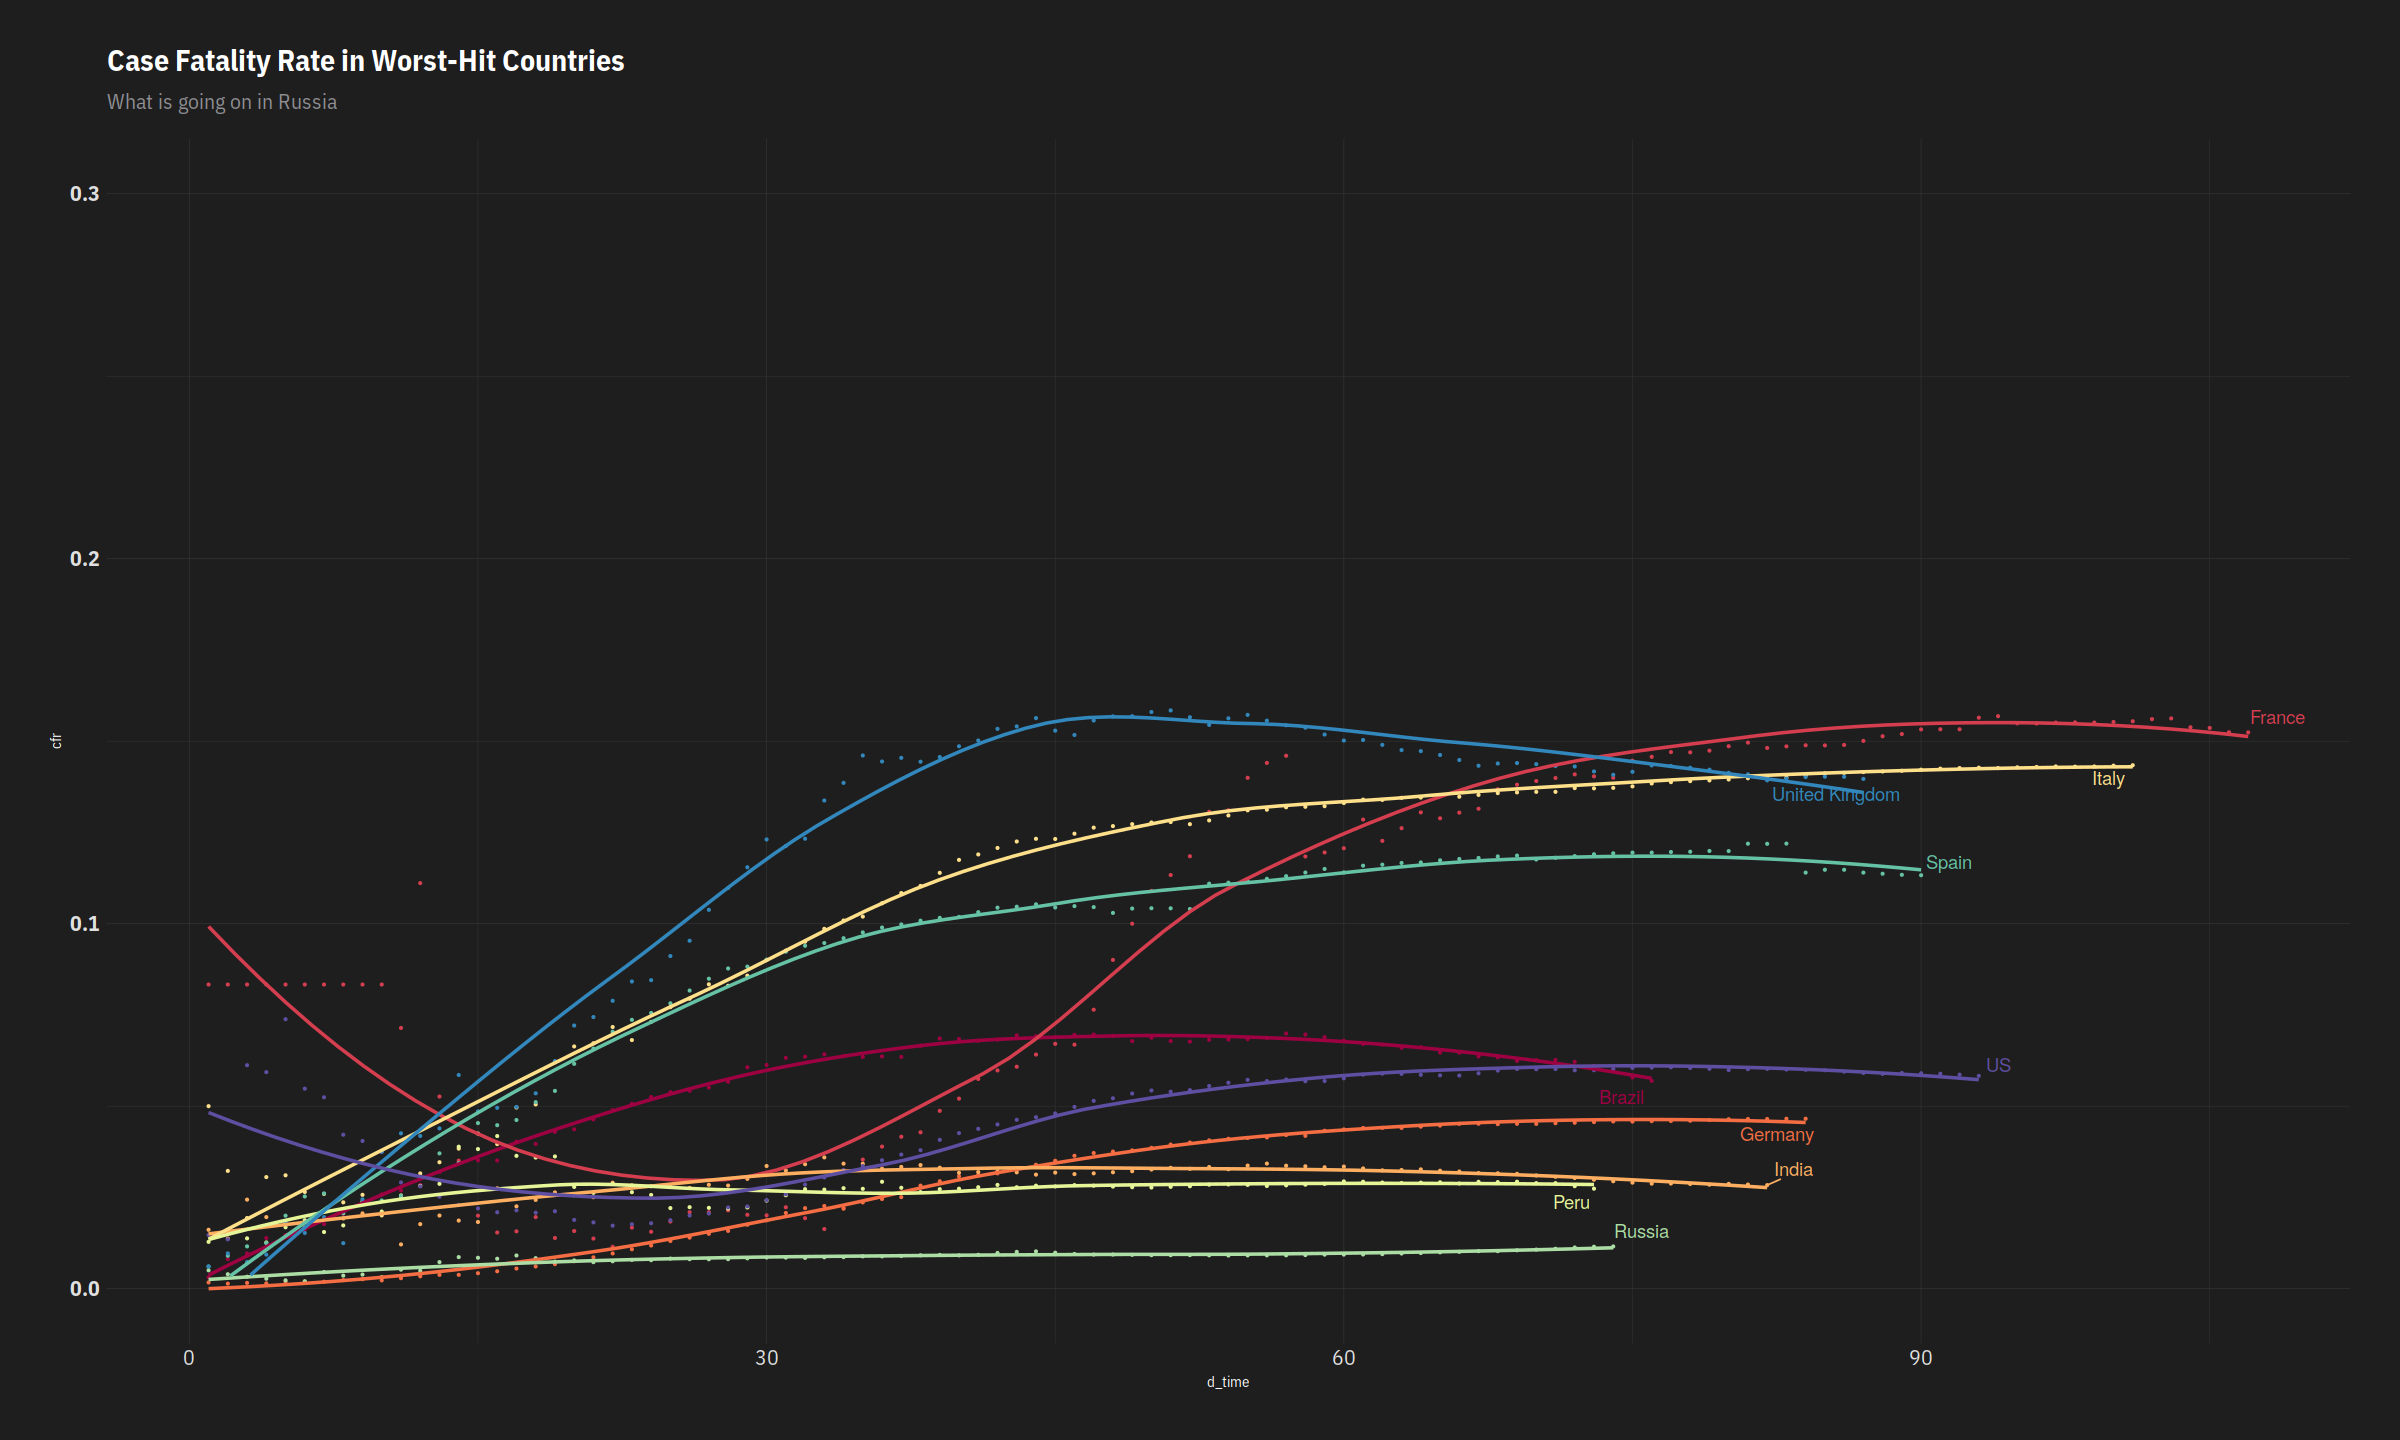

In [15]:
p3 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = cfr, group = Country_Region, colour = Country_Region)) + 
    geom_point(size = 0.5) + 
#     geom_line(aes(y = rm7_cfr)) + 
    geom_smooth(se = F) +
    ylim(c(0, 0.3)) +
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      na.rm = TRUE) +
    labs(title = 'Case Fatality Rate in Worst-Hit Countries', subtitle = "What is going on in Russia")
p3

## Shares

In [16]:
t10_subset[, denom_cases := sum(rm7_new_cases), by = date][, 
            denom_deaths := sum(rm7_new_deaths), by = date]
t10_subset[, newcase_share := rm7_new_cases / denom_cases][, 
            newdeath_share := rm7_new_deaths /denom_deaths]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 37 rows containing missing values (position_stack).”


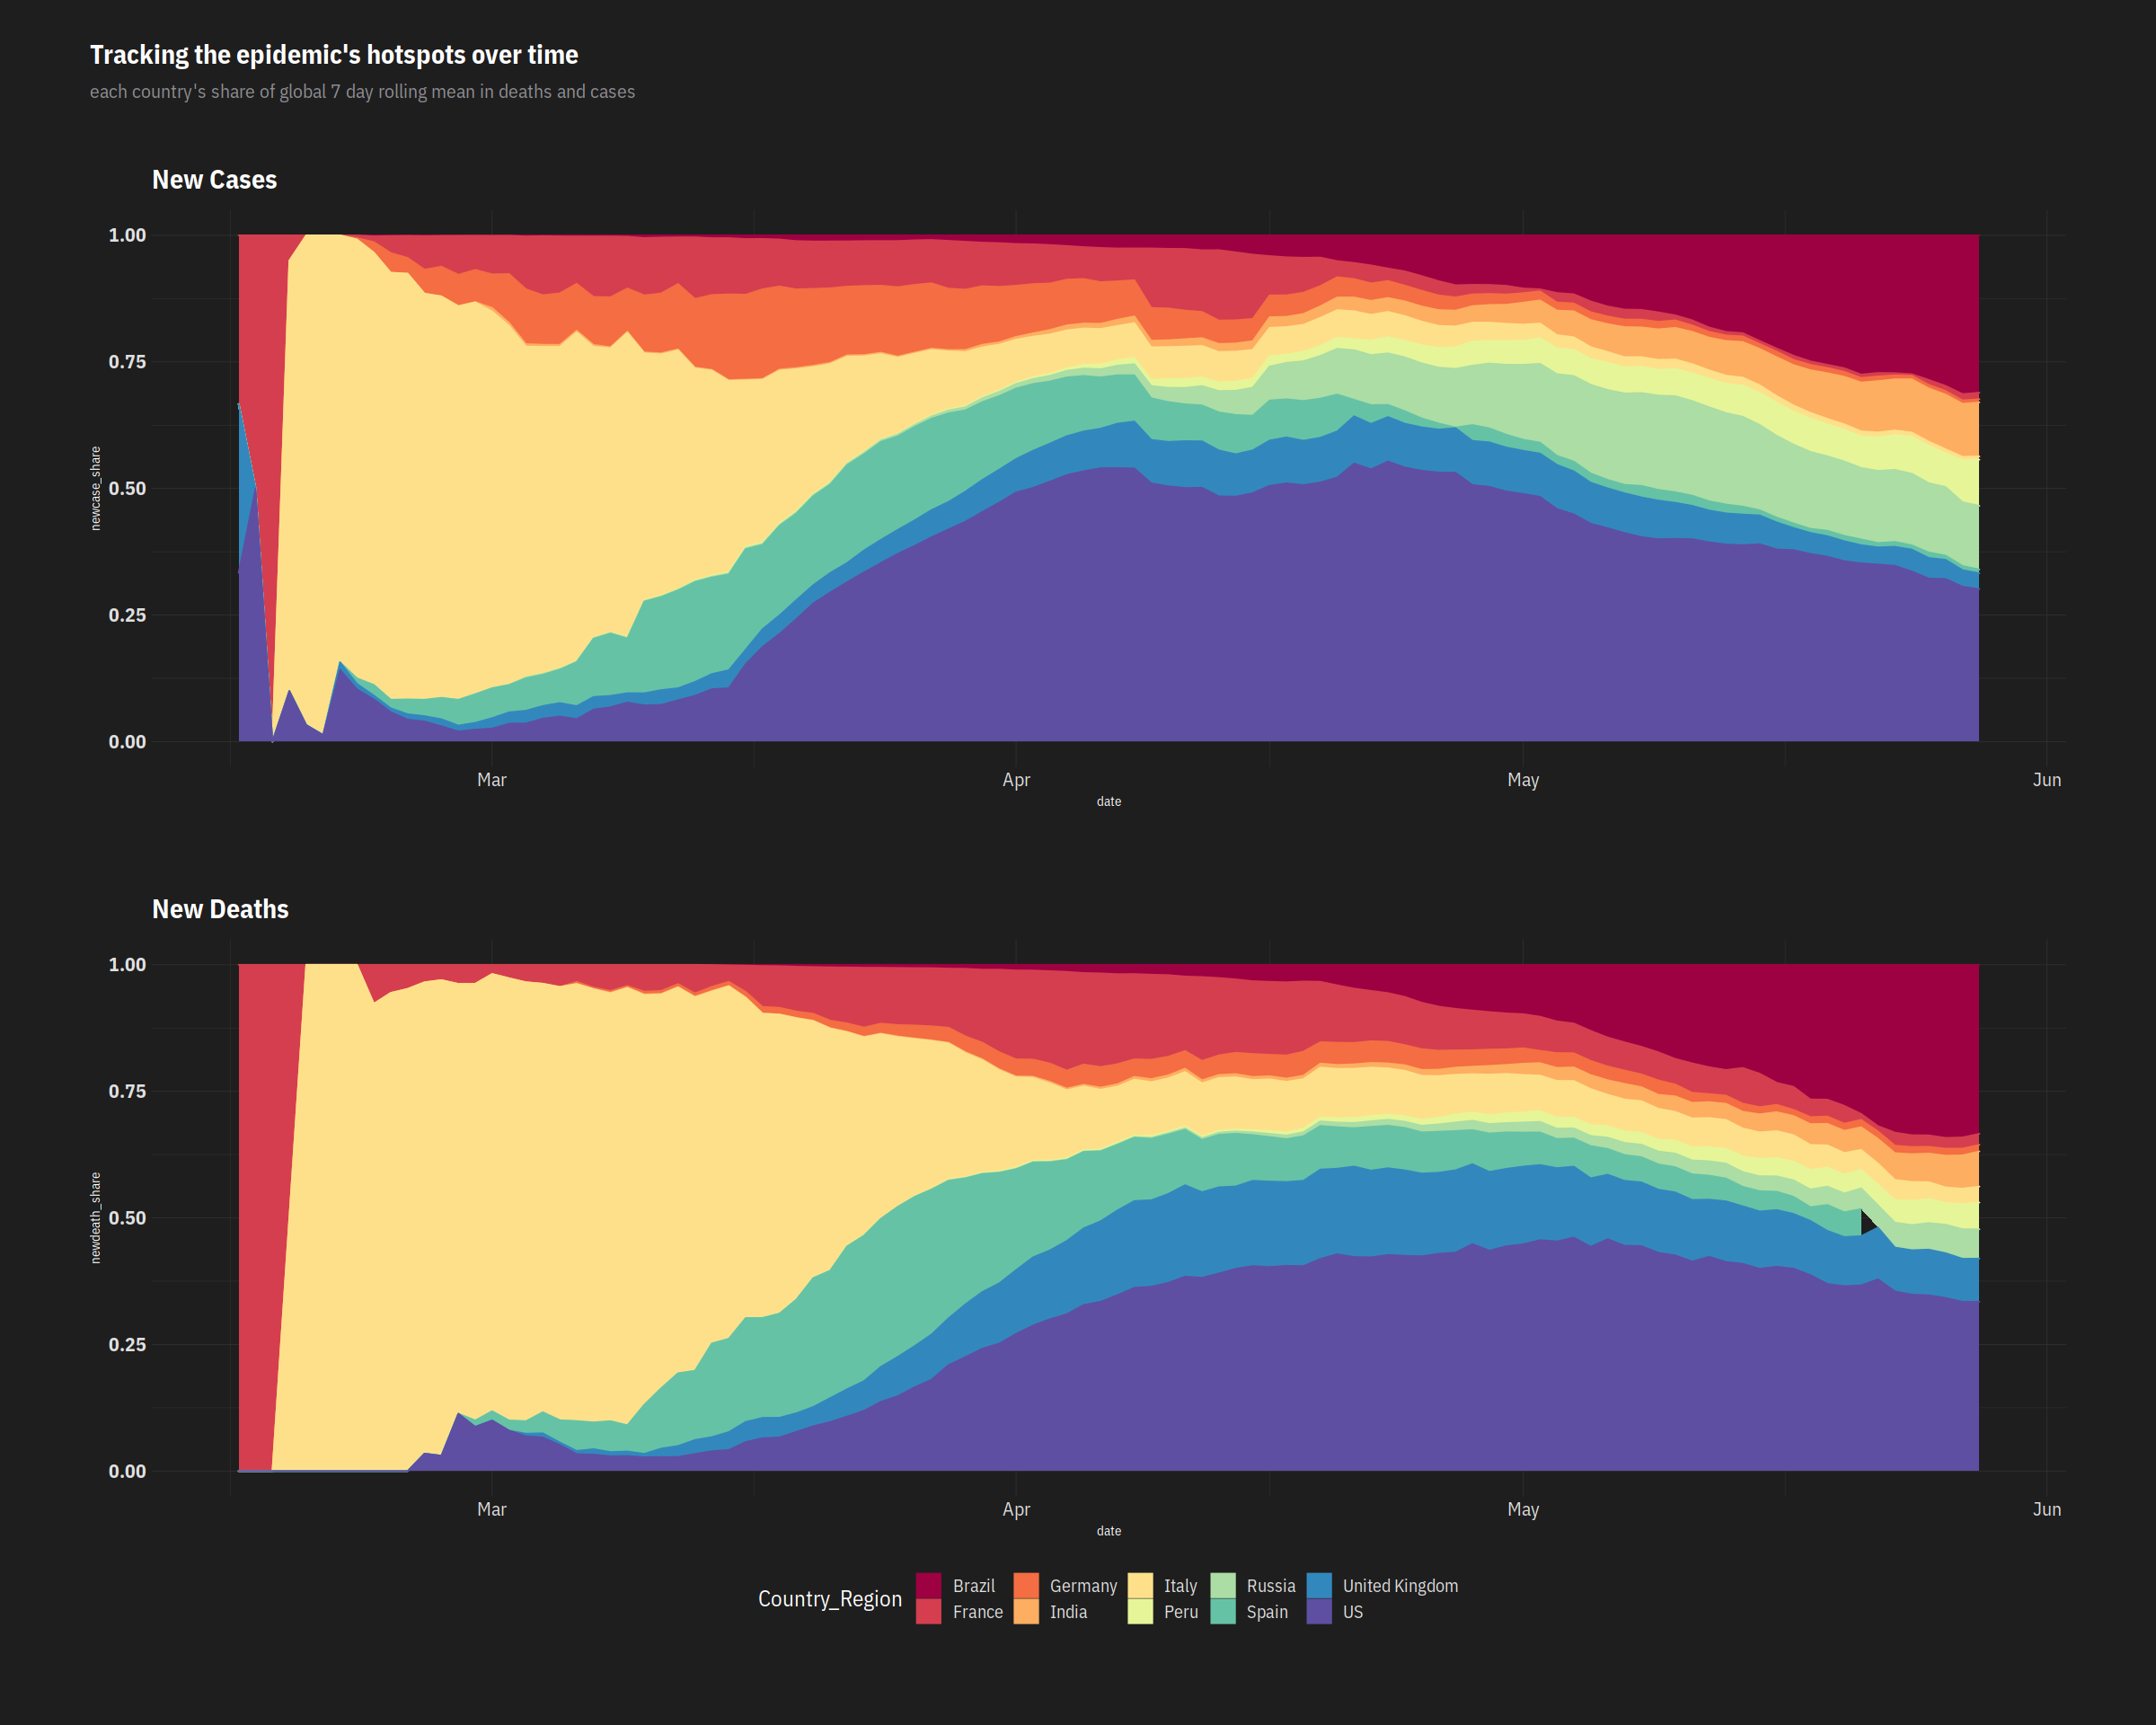

In [21]:
p1 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newcase_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases") + theme(legend.position = "None")
p2 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newdeath_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")

options(repr.plot.width = 20, repr.plot.height = 16)
(p = (p1 / p2 ) + plot_annotation(title = "Tracking the epidemic's hotspots over time", 
                                  subtitle = "each country's share of global 7 day rolling mean in deaths and cases"))

In [17]:
# ggsave("carpet_plot.jpg", p, device = cairo_pdf, width = 20, height = 16)

# OWID 

In [22]:
owid = fread("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid[, d := ymd(date)]
owid %>% glimpse

Rows: 21,186
Columns: 33
$ iso_code                        <chr> "ABW", "ABW", "ABW", "ABW", "ABW", "A…
$ location                        <chr> "Aruba", "Aruba", "Aruba", "Aruba", "…
$ date                            <chr> "2020-03-13", "2020-03-20", "2020-03-…
$ total_cases                     <int> 2, 4, 12, 17, 19, 28, 28, 28, 50, 55,…
$ new_cases                       <int> 2, 2, 8, 5, 2, 9, 0, 0, 22, 5, 0, 5, …
$ total_deaths                    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_deaths                      <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_cases_per_million         <dbl> 18.73, 37.47, 112.39, 159.23, 177.96,…
$ new_cases_per_million           <dbl> 18.733, 18.733, 74.930, 46.831, 18.73…
$ total_deaths_per_million        <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.…
$ new_deaths_per_million          <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.…
$ total_tests                     <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ new_tests                

In [23]:
fwrite(owid, "data/owid_covid.csv")

In [24]:
all_countries_xs = owid[location!="World"][
    order(-d)][
    , .SD[1], by = .(iso_code)]
(t10 = all_countries_xs[order(-total_cases)][1:10])
#  [order(-total_cases)][1:10])

iso_code location       date       total_cases new_cases total_deaths
1  USA      United States  2020-06-01 1790191     19807     104383      
2  BRA      Brazil         2020-06-01  514849     16409      29314      
3  RUS      Russia         2020-06-01  405843      9268       4693      
4  GBR      United Kingdom 2020-06-01  274762      1936      38489      
5  ESP      Spain          2020-05-31  239429       201      27127      
6  ITA      Italy          2020-06-01  233019       355      33415      
7  IND      India          2020-06-01  190535      8392       5394      
8  DEU      Germany        2020-06-01  181815       333       8511      
9  PER      Peru           2020-06-01  164476      8805       4506      
10 TUR      Turkey         2020-06-01  163942       839       4540      
   new_deaths total_cases_per_million new_cases_per_million
1  602        5408.4                   59.839              
2  480        2422.1                   77.197              
3  138        2781.0                   63.508              
4  113        4047.4                   28.518              
5    2        5121.0                    4.299              
6   75        3854.0                    5.871              
7  230         138.1                    6.081              
8   11        2170.0                    3.975              
9  135        4988.4                  267.046              
10  25        1943.8                    9.948              
   total_deaths_per_million ⋯ aged_70_older gdp_per_capita extreme_poverty
1  315.354                  ⋯  9.732        54225           1.2           
2  137.910                  ⋯  5.060        14103           3.4           
3   32.158                  ⋯  9.393        24766           0.1           
4  566.965                  ⋯ 12.527        39753           0.2           
5  580.197                  ⋯ 13.799        34272           1.0           
6  552.663                  ⋯ 16.240        35220           2.0           
7    3.909                  ⋯  3.414         6427          21.2           
8  101.583                  ⋯ 15.957        45229            NA           
9  136.662                  ⋯  4.455        12237           3.5           
10  53.830                  ⋯  5.061        25129           0.2           
   cvd_death_rate diabetes_prevalence female_smokers male_smokers
1  151.09         10.79               19.1           24.6        
2  177.96          8.11               10.1           17.9        
3  431.30          6.18               23.4           58.3        
4  122.14          4.28               20.0           24.7        
5   99.40          7.17               27.4           31.4        
6  113.15          4.78               19.8           27.8        
7  282.28         10.39                1.9           20.6        
8  156.14          8.31               28.2           33.1        
9   85.75          5.95                4.8             NA        
10 171.28         12.13               14.1           41.1        
   handwashing_facilities hospital_beds_per_100k d         
1     NA                  2.77                   2020-06-01
2     NA                  2.20                   2020-06-01
3     NA                  8.05                   2020-06-01
4     NA                  2.54                   2020-06-01
5     NA                  2.97                   2020-05-31
6     NA                  3.18                   2020-06-01
7  59.55                  0.53                   2020-06-01
8     NA                  8.00                   2020-06-01
9     NA                  1.60                   2020-06-01
10    NA                  2.81                   2020-06-01

In [25]:
owid_t10_subset = owid[location %in% t10$location]

vars = c('new_cases', 'new_deaths', 'new_tests')
owid_t10_subset[, paste0('denom_', vars):= lapply(.SD, sum), by = date, .SDcols = vars]

owid_t10_subset[, `:=`(
            newcase_share  = new_cases / denom_new_cases,
            newdeath_share = new_deaths / denom_new_deaths,
            newtest_share  = new_tests / denom_new_tests
    )][ newcase_share < 0, newcase_share := 0]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 48 rows containing missing values (position_stack).”
Warning message:
“Removed 82 rows containing missing values (position_stack).”


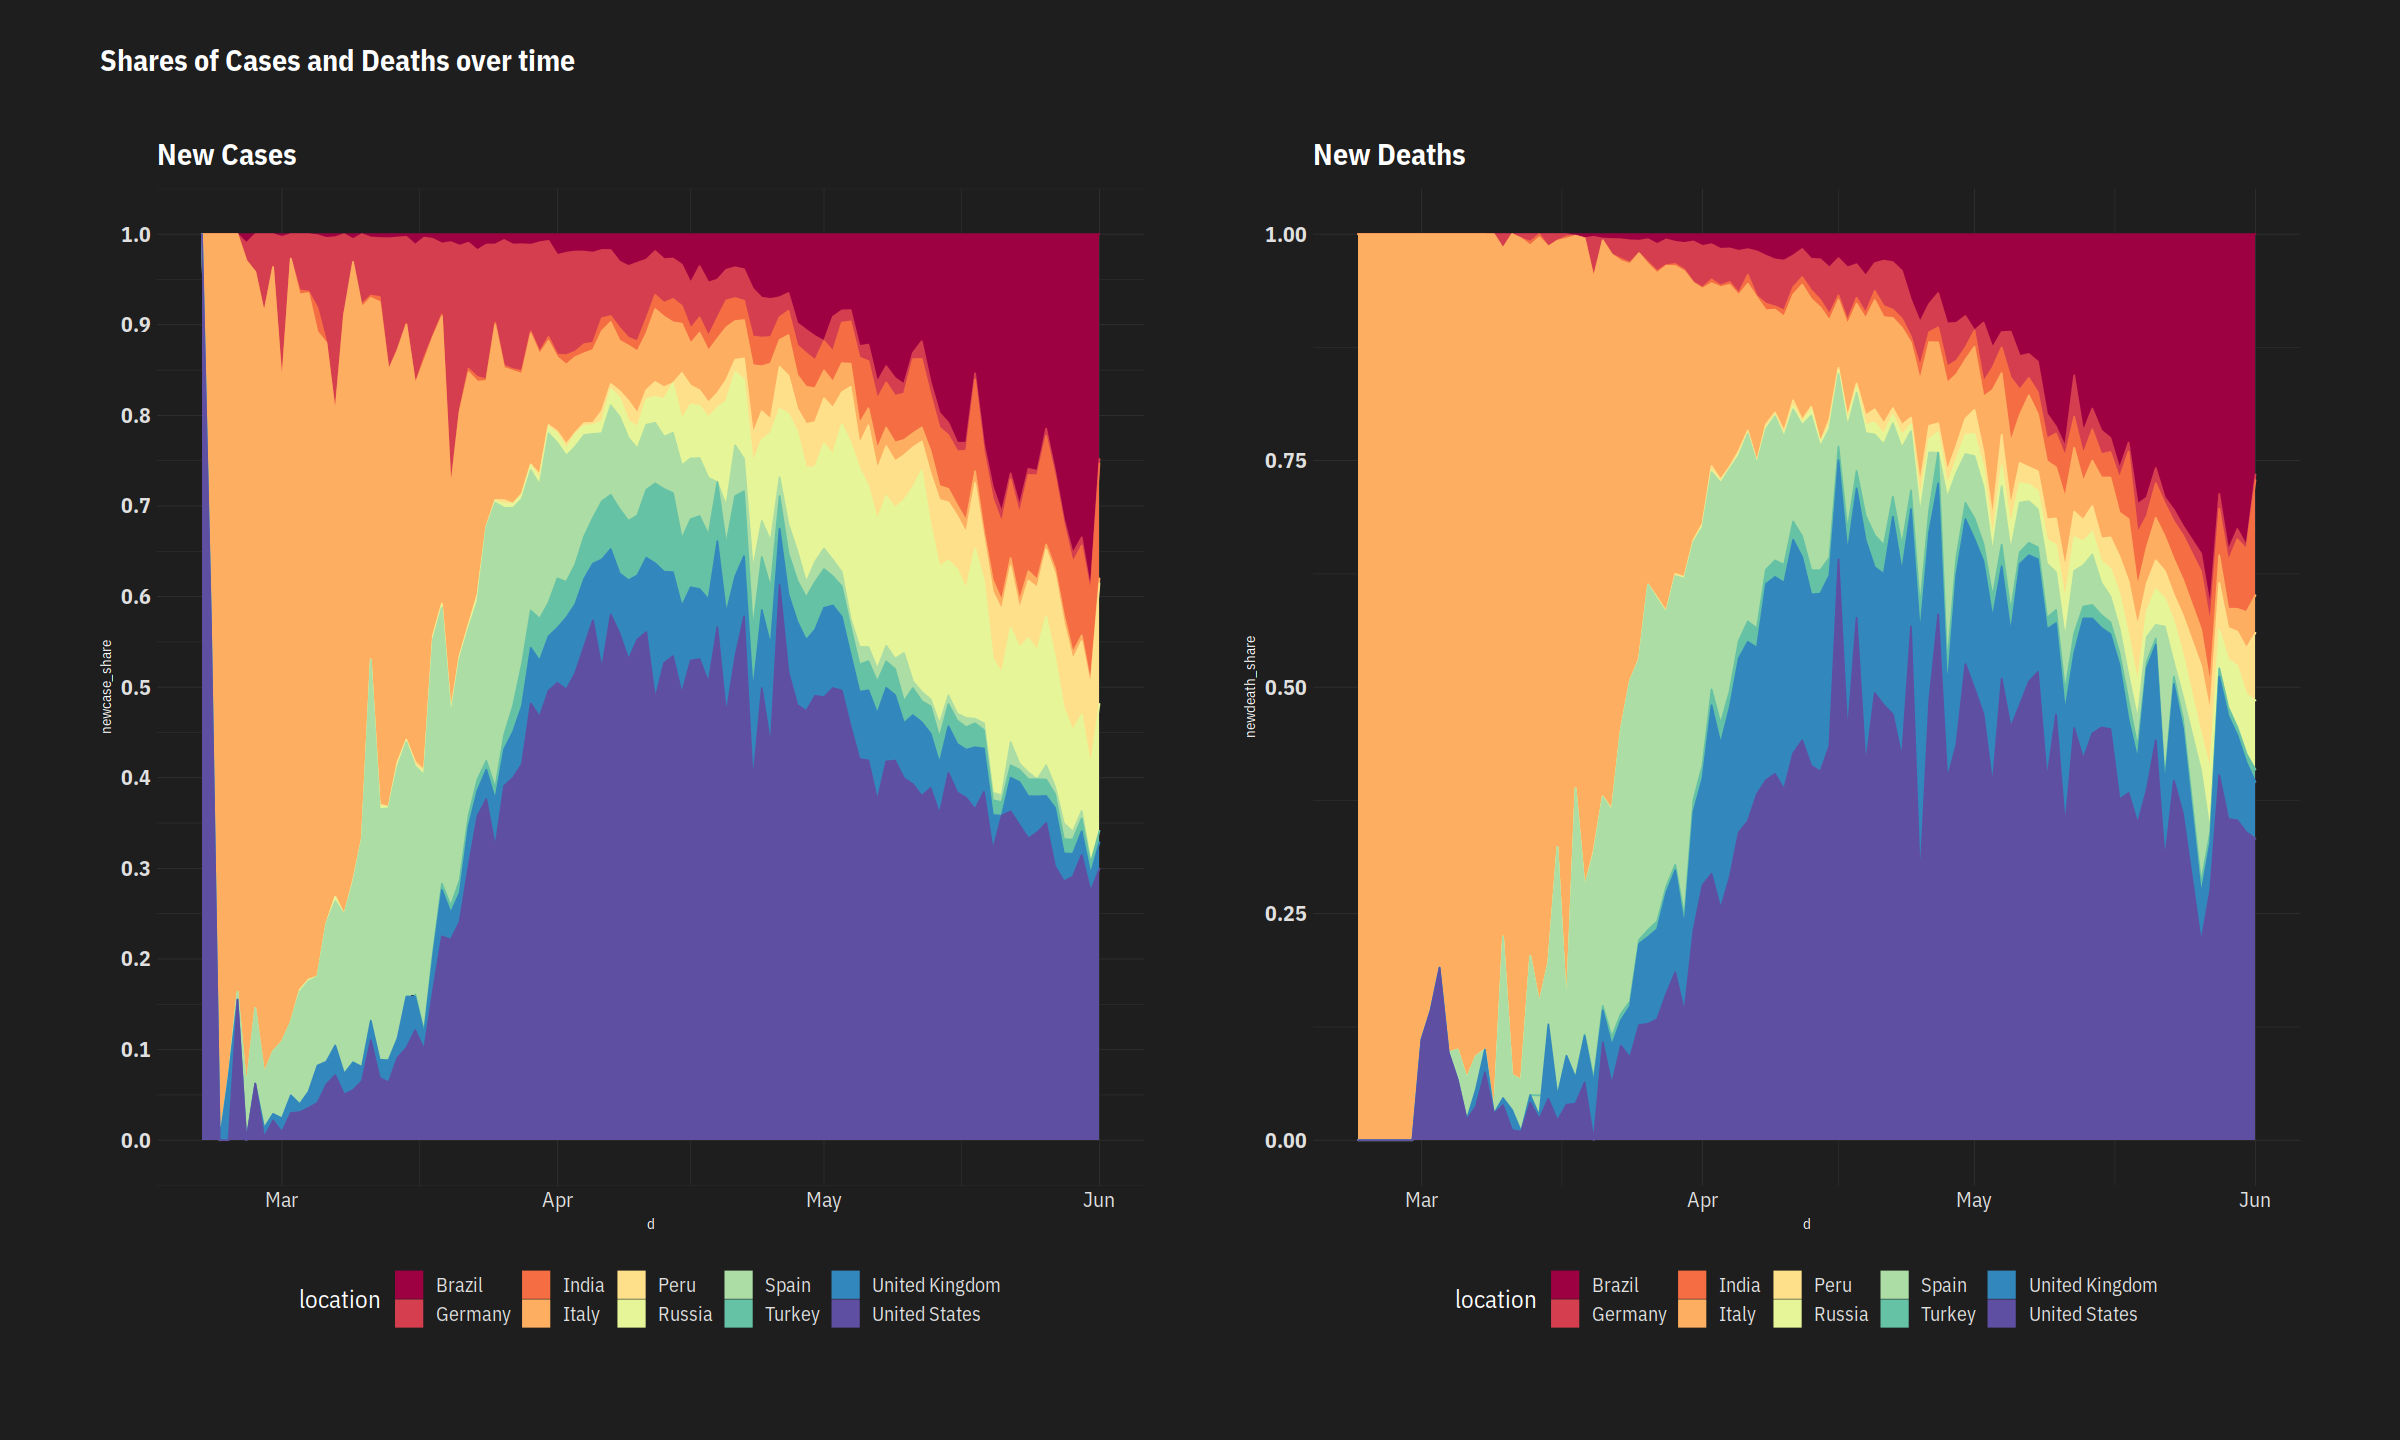

In [26]:
p1 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newcase_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newdeath_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") + ylim(c(0, 1)) +
    ggtitle("New Deaths")
options(repr.plot.width = 20, repr.plot.height = 12)
(p1 | p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")

## Country Profiles 

In [27]:
country_plot = function(country){
    npl = owid[location == country][order(-date)]
    p1 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_cases)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Cases') 
    
    p2 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_cases)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Cases')
    
    p3 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Deaths')
    
    p4 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Deaths')

    p5 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_tests)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Tests')

    p6 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_tests)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Tests')
    suppressMessages(suppressWarnings(print(
        (p5 | p6) / (p1 | p2) / (p3 | p4) + plot_annotation(title = paste0("Covid Profile : ", country))
    )))
}


## South Asia

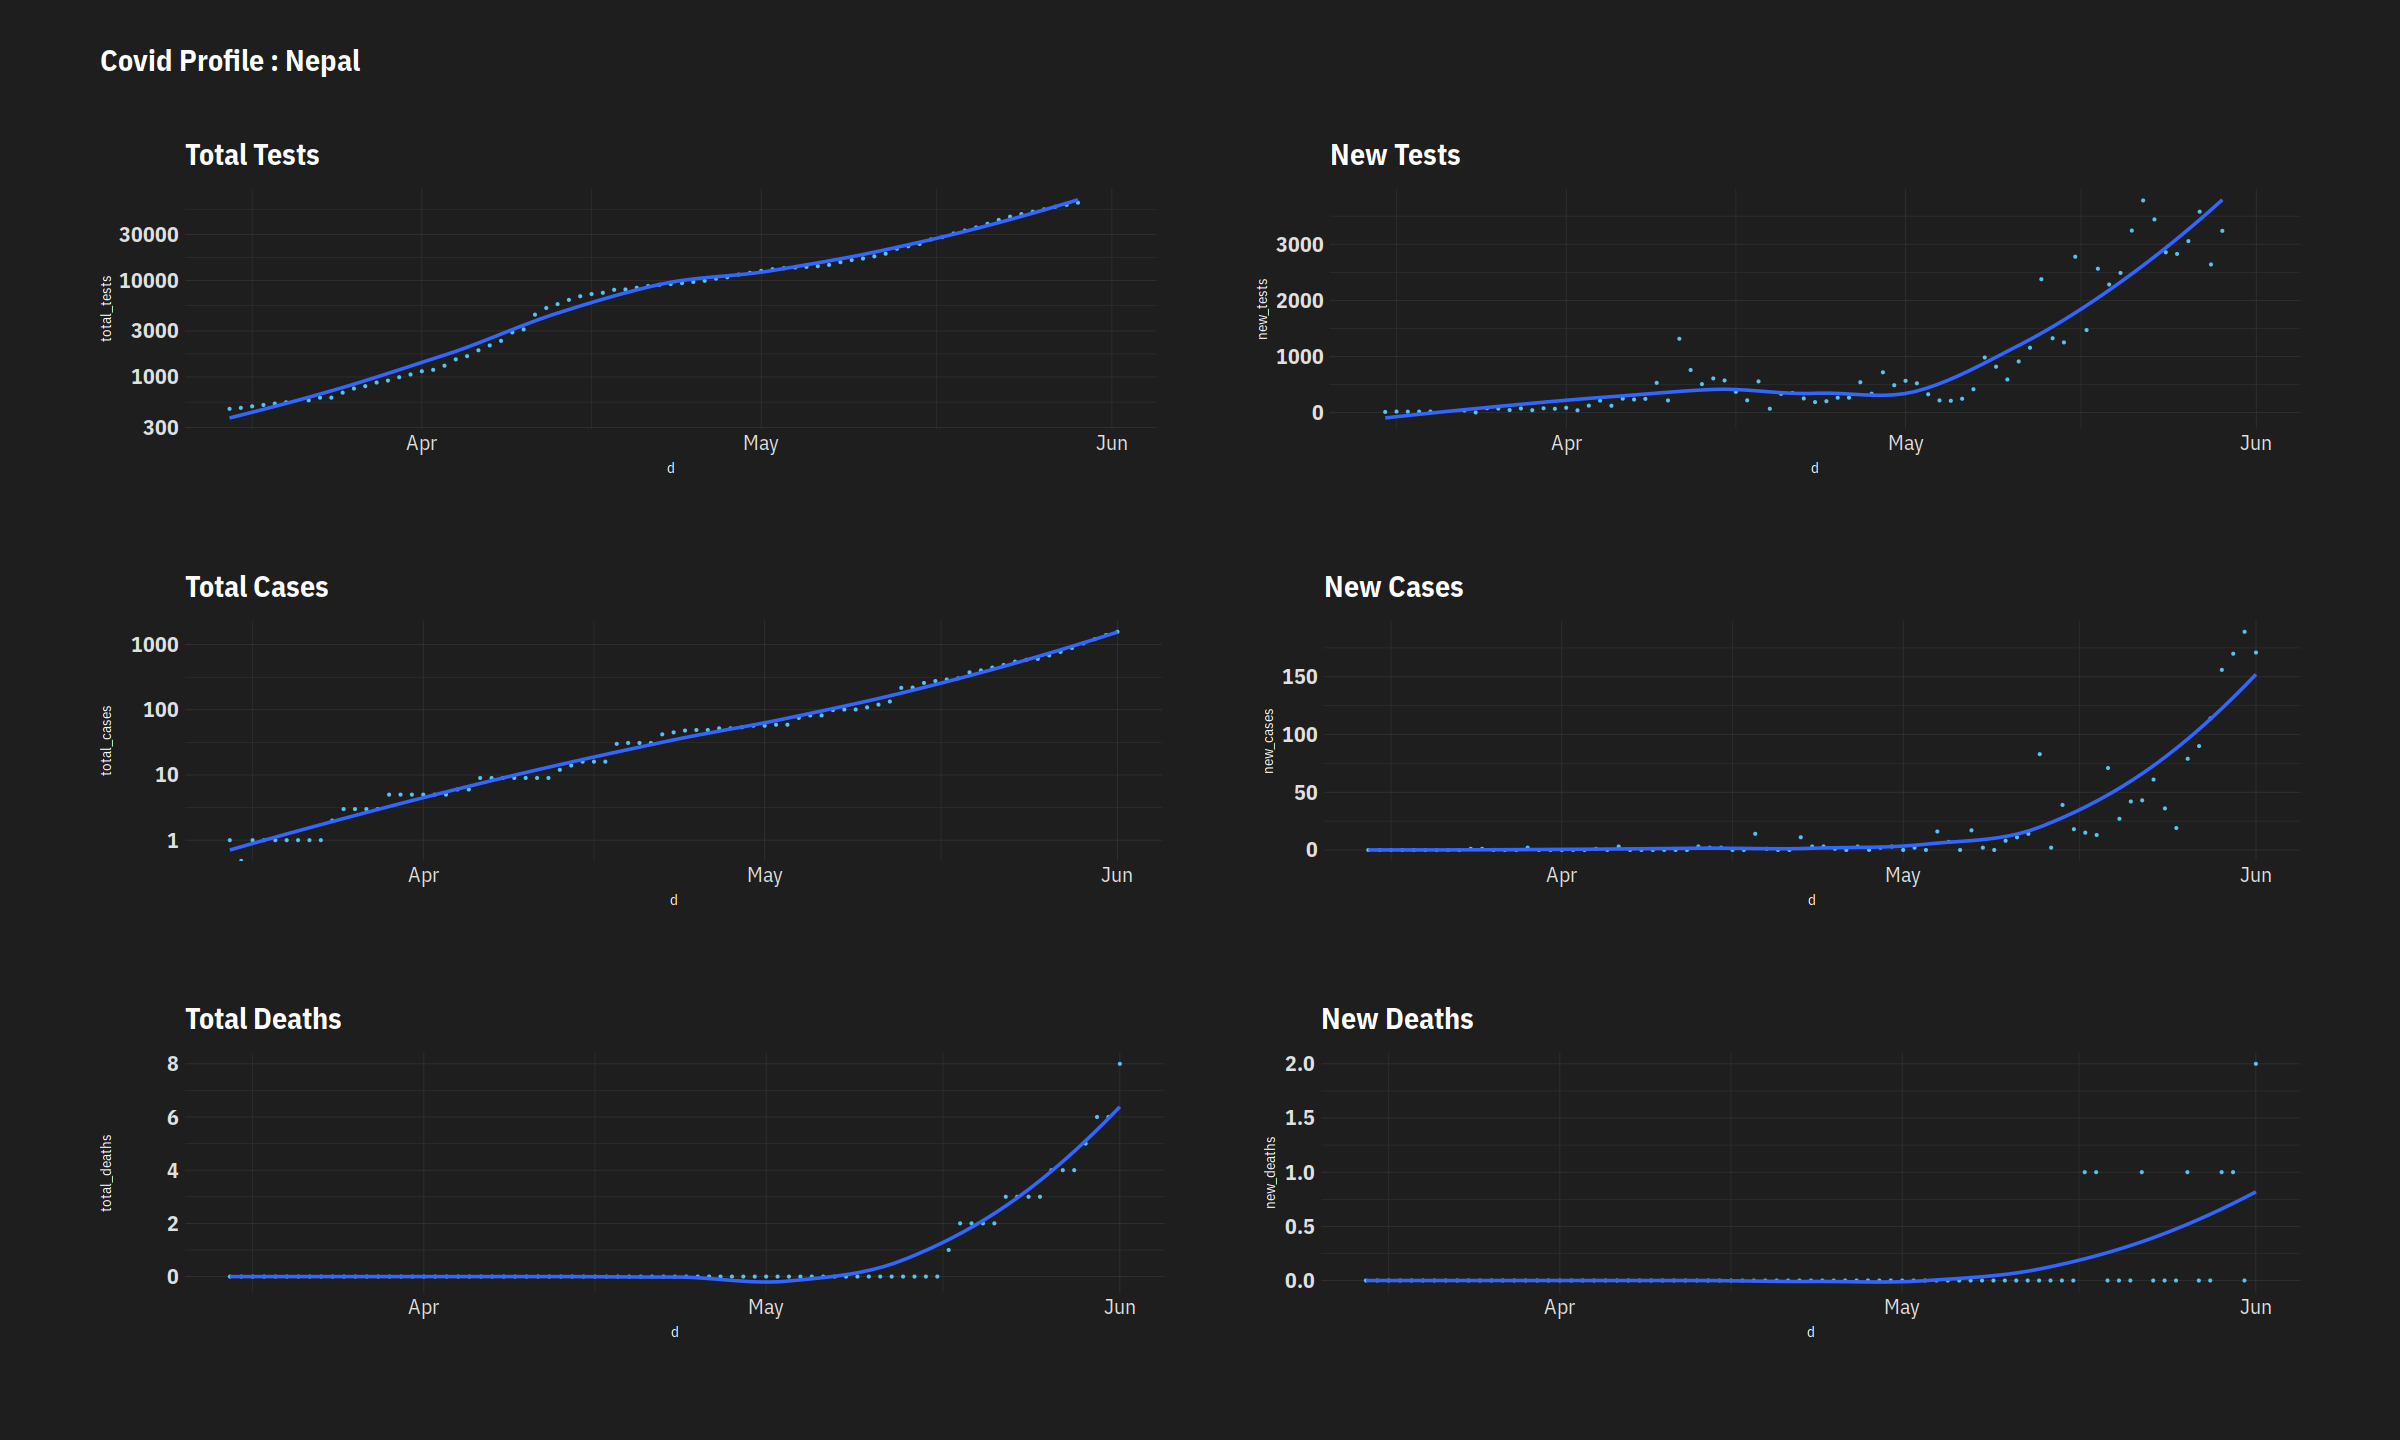

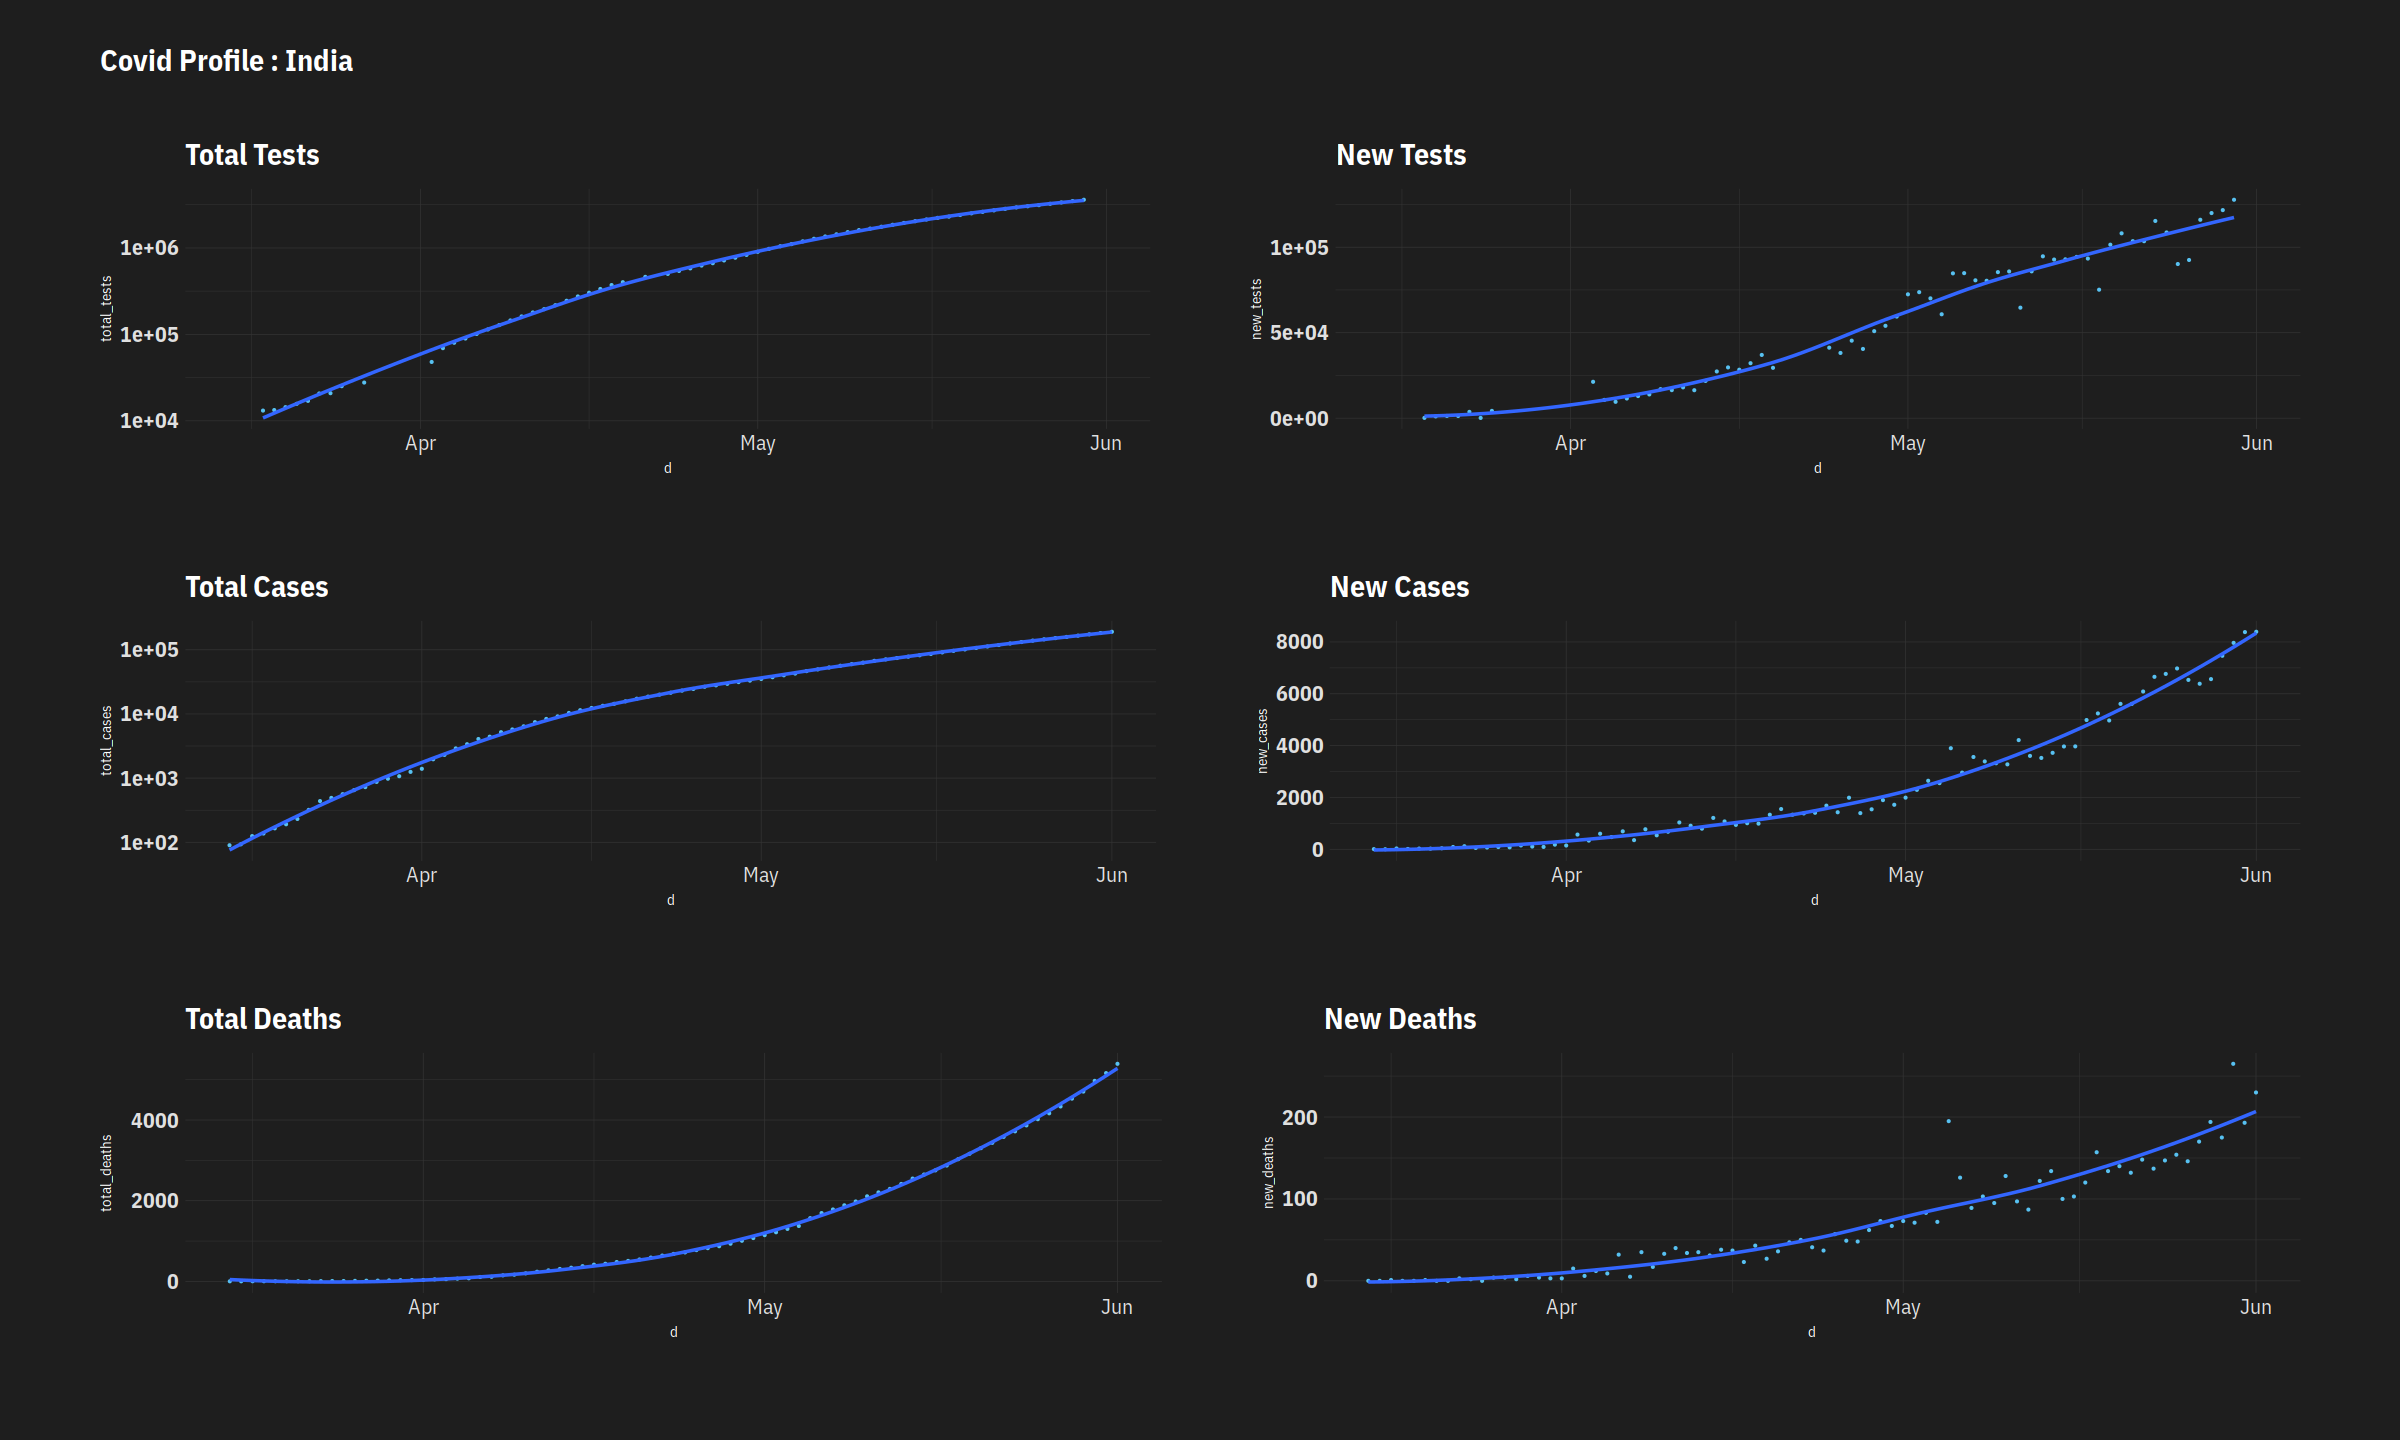

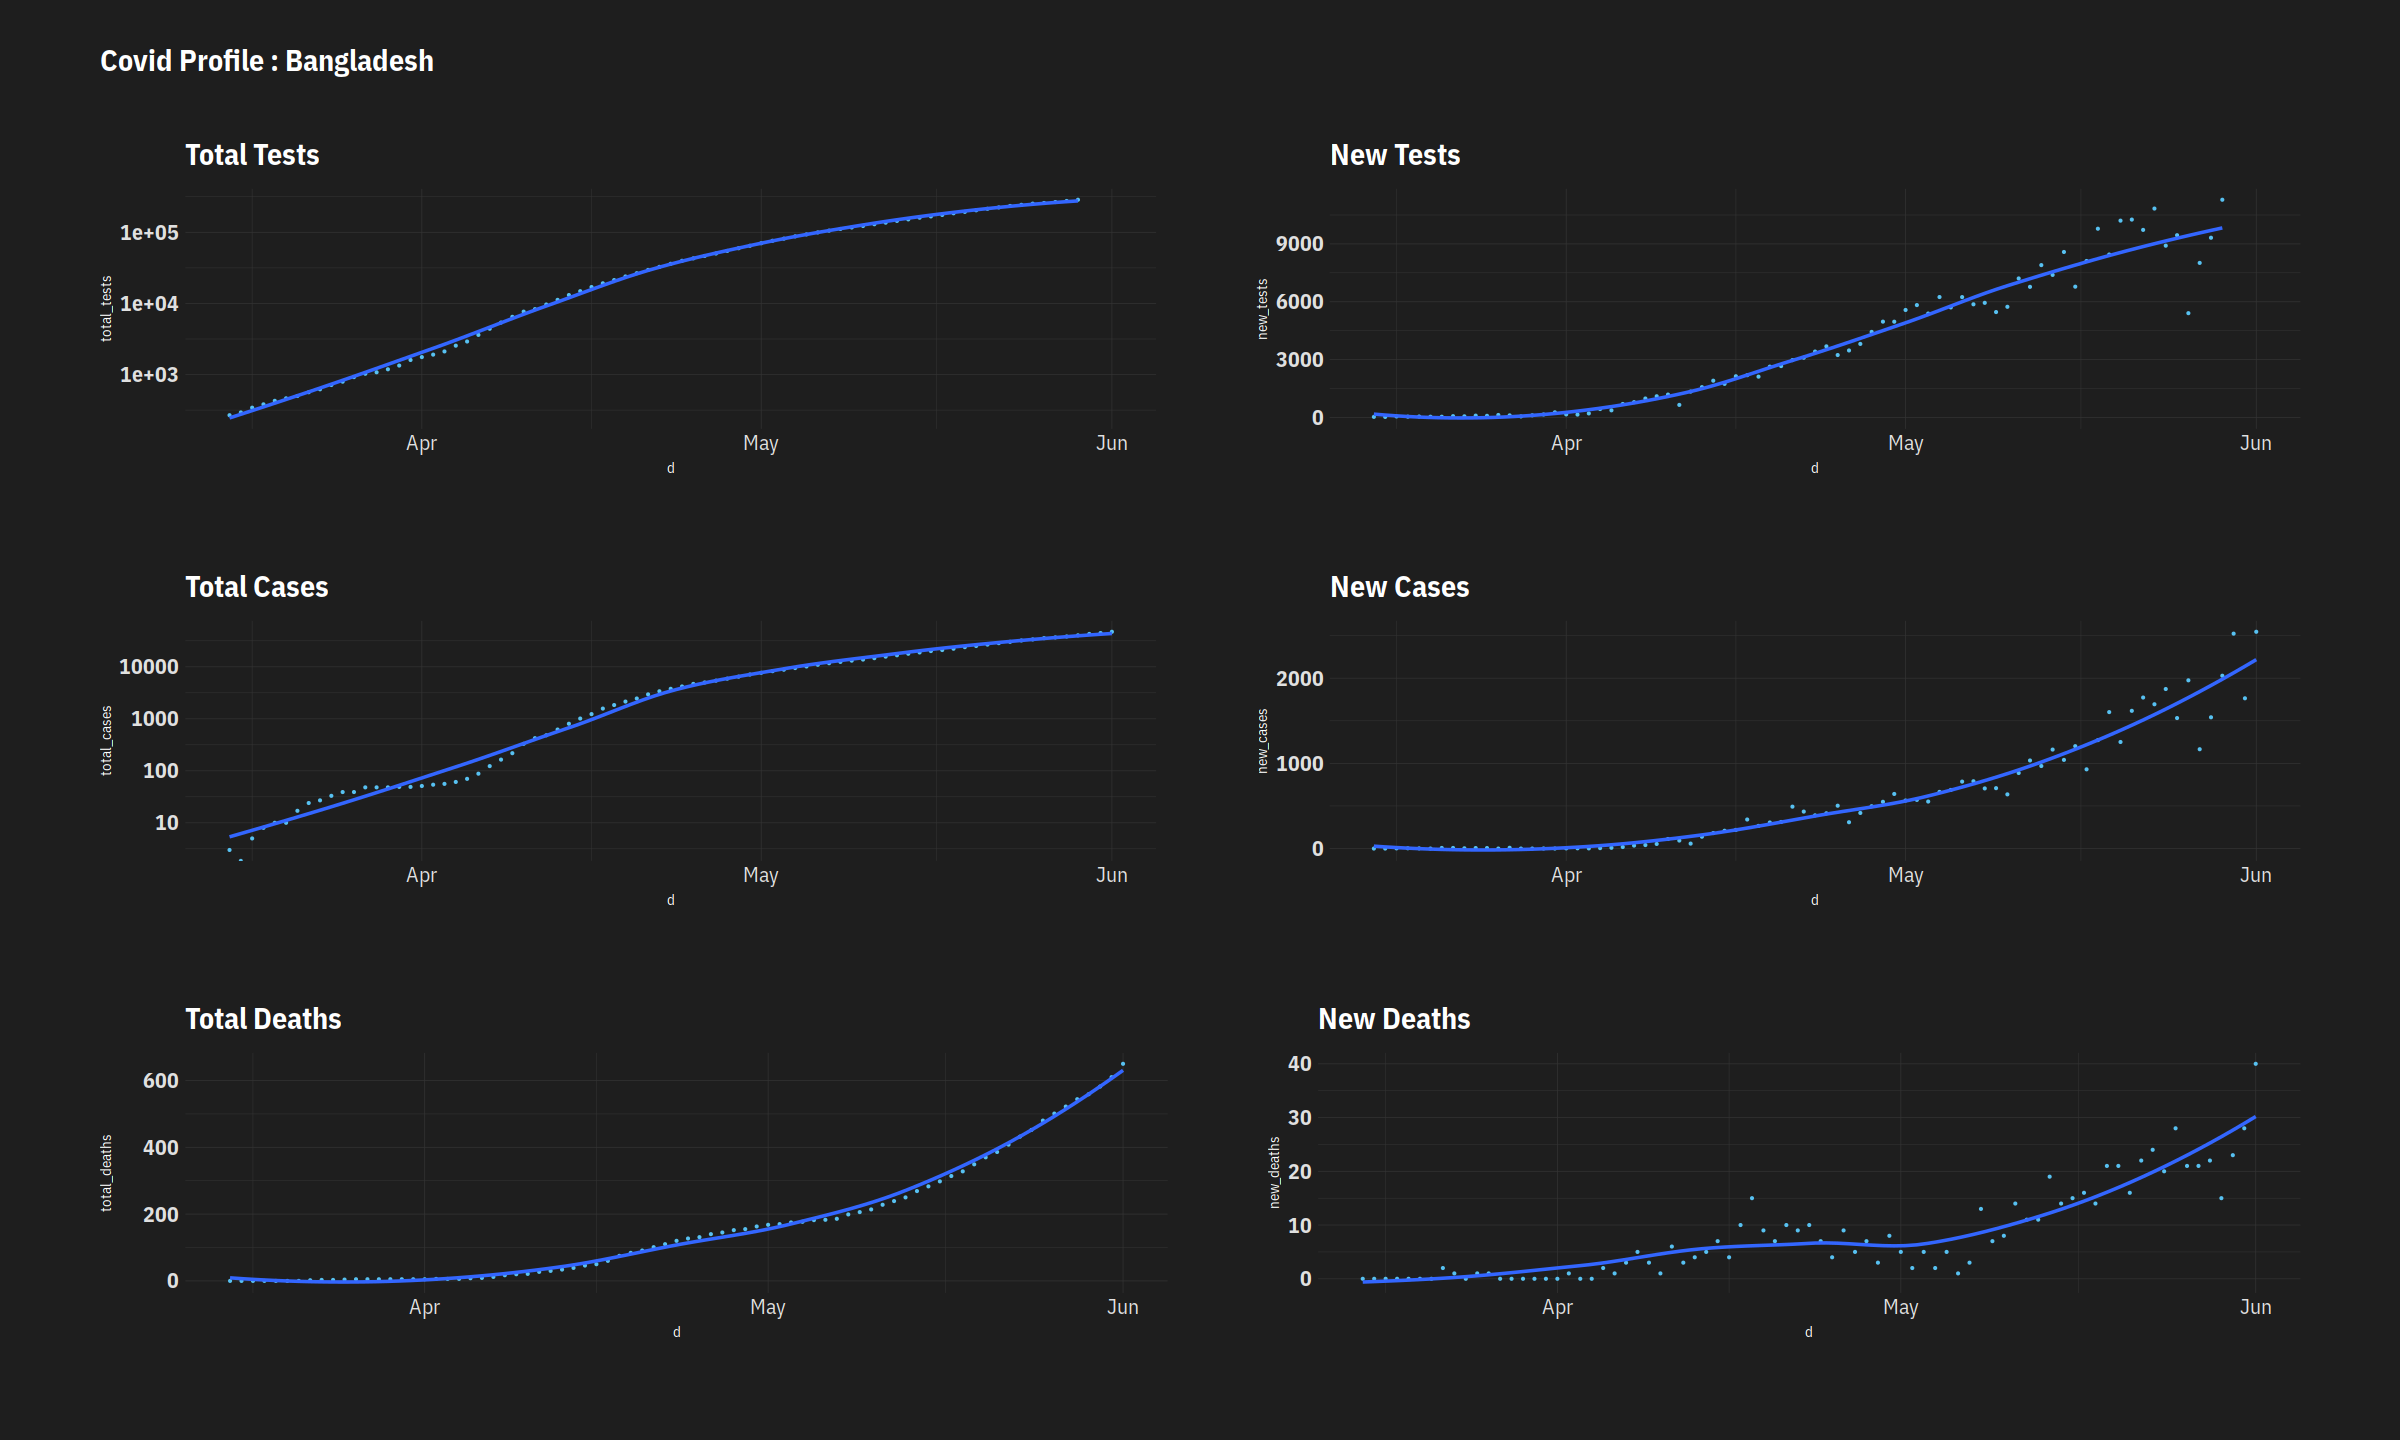

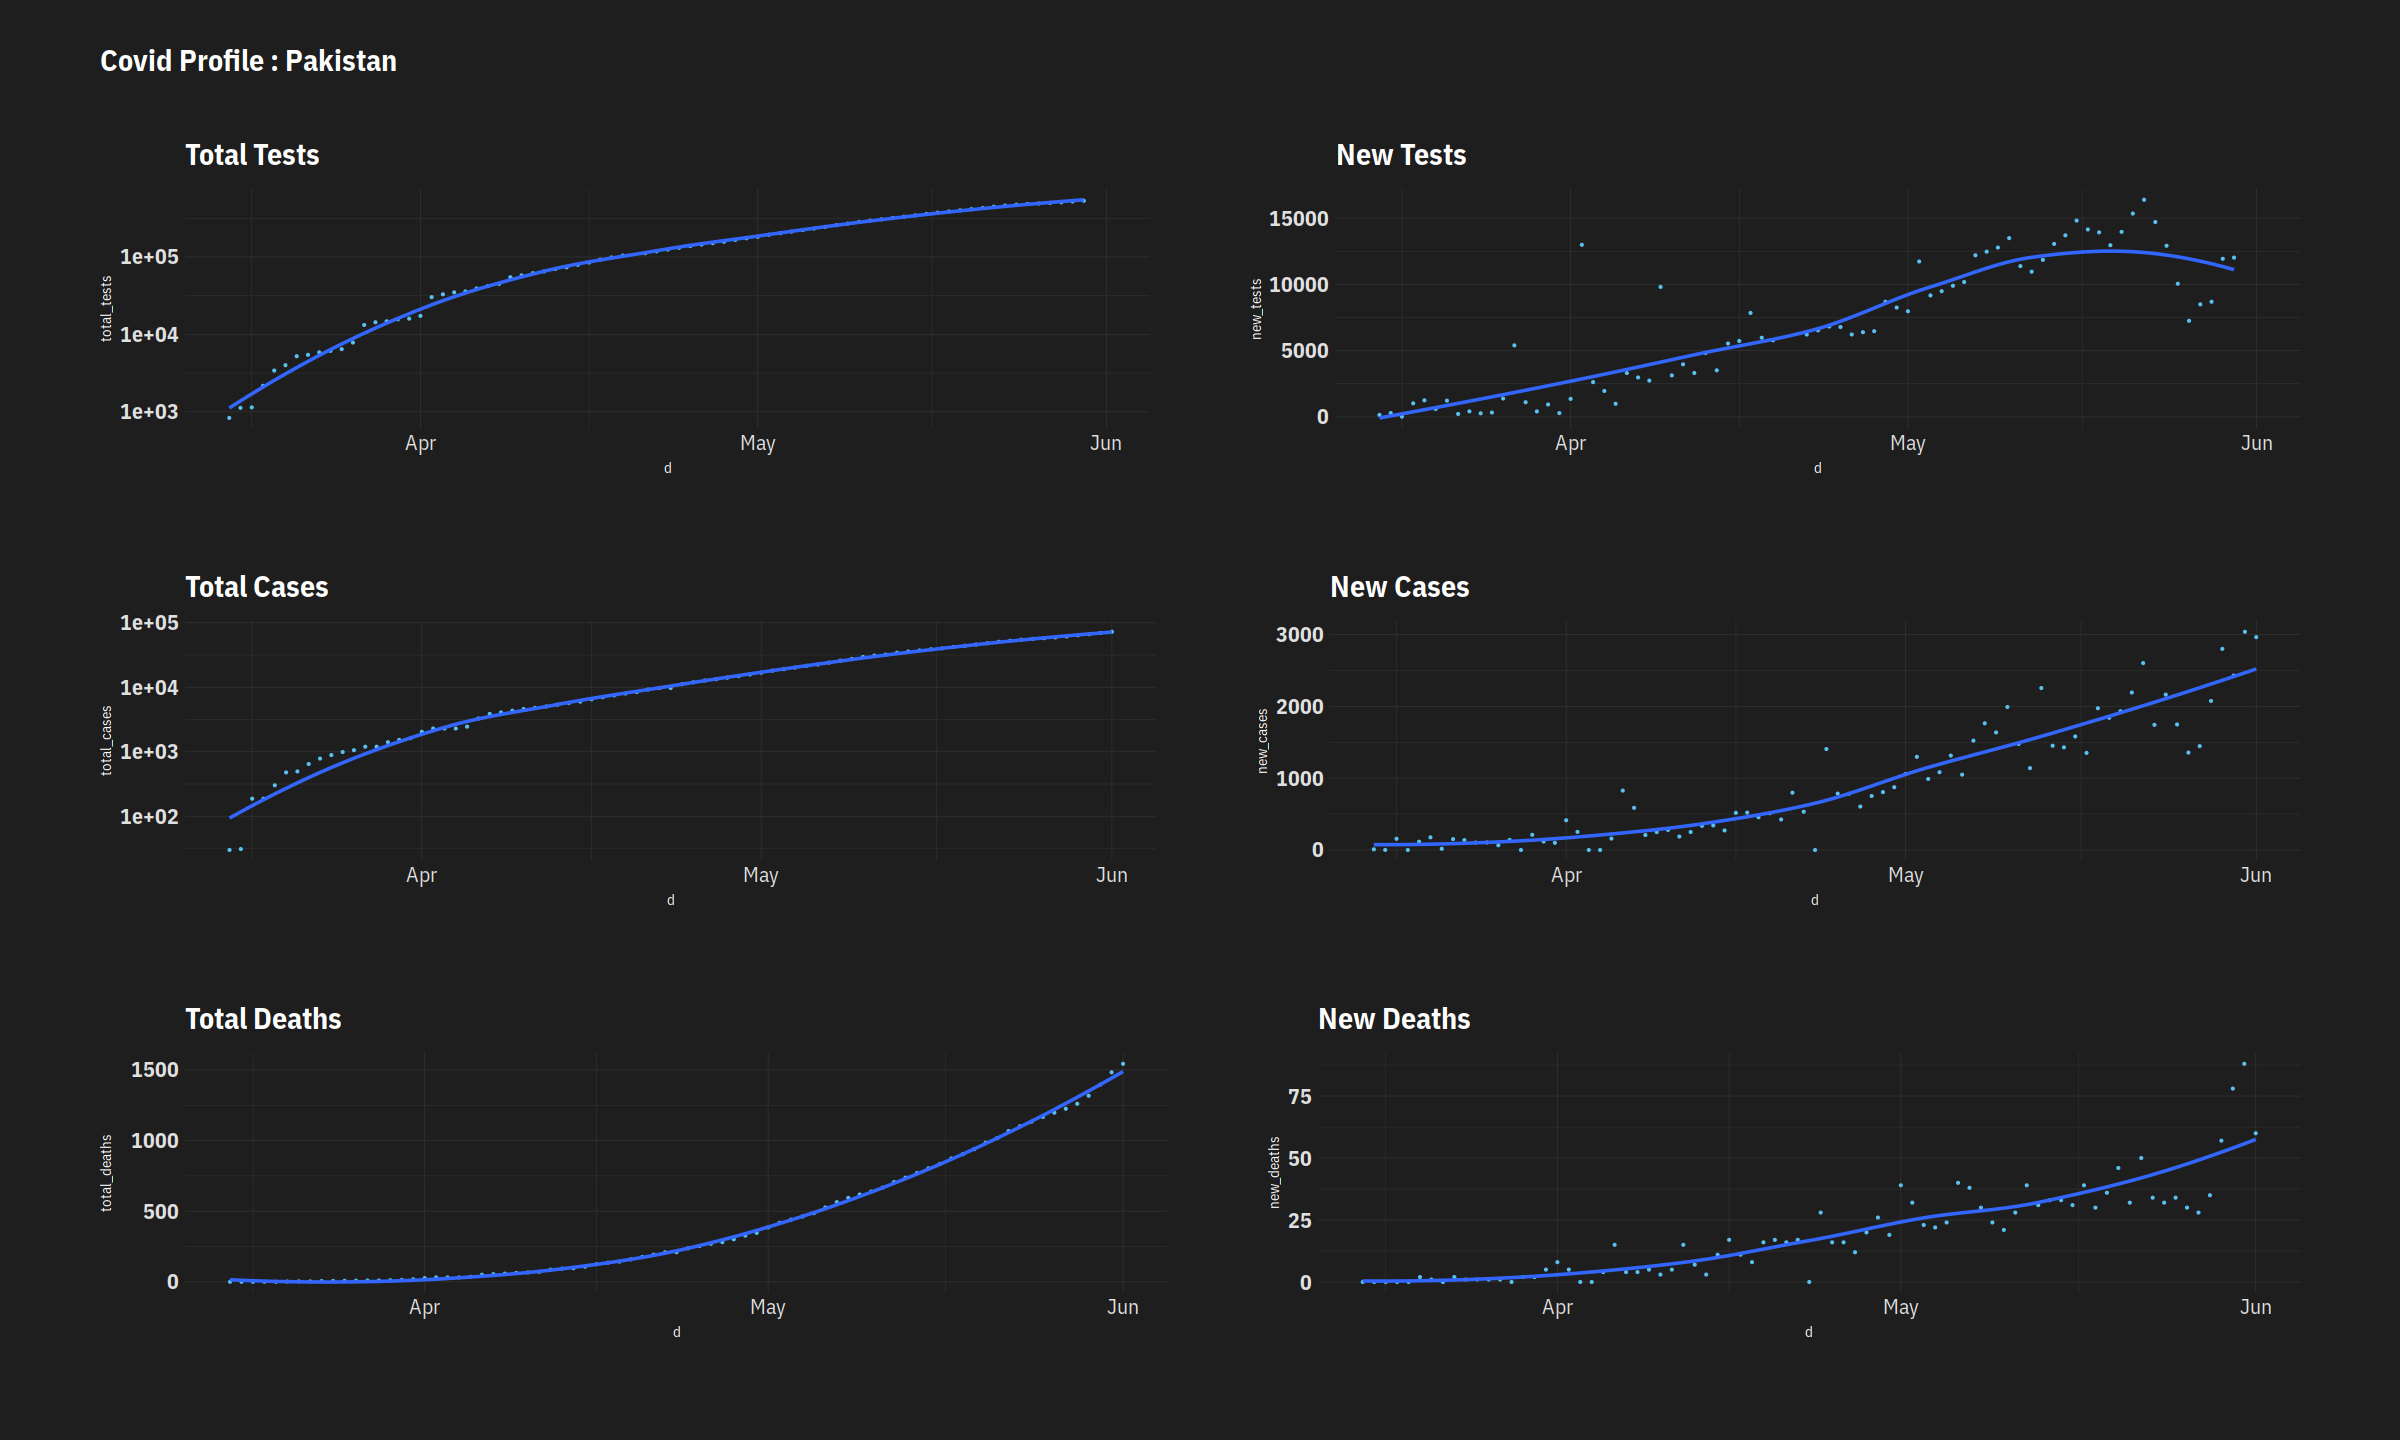

In [28]:
country_plot("Nepal") 
country_plot("India")
country_plot("Bangladesh")
country_plot("Pakistan")

## Sub-Saharan Africa

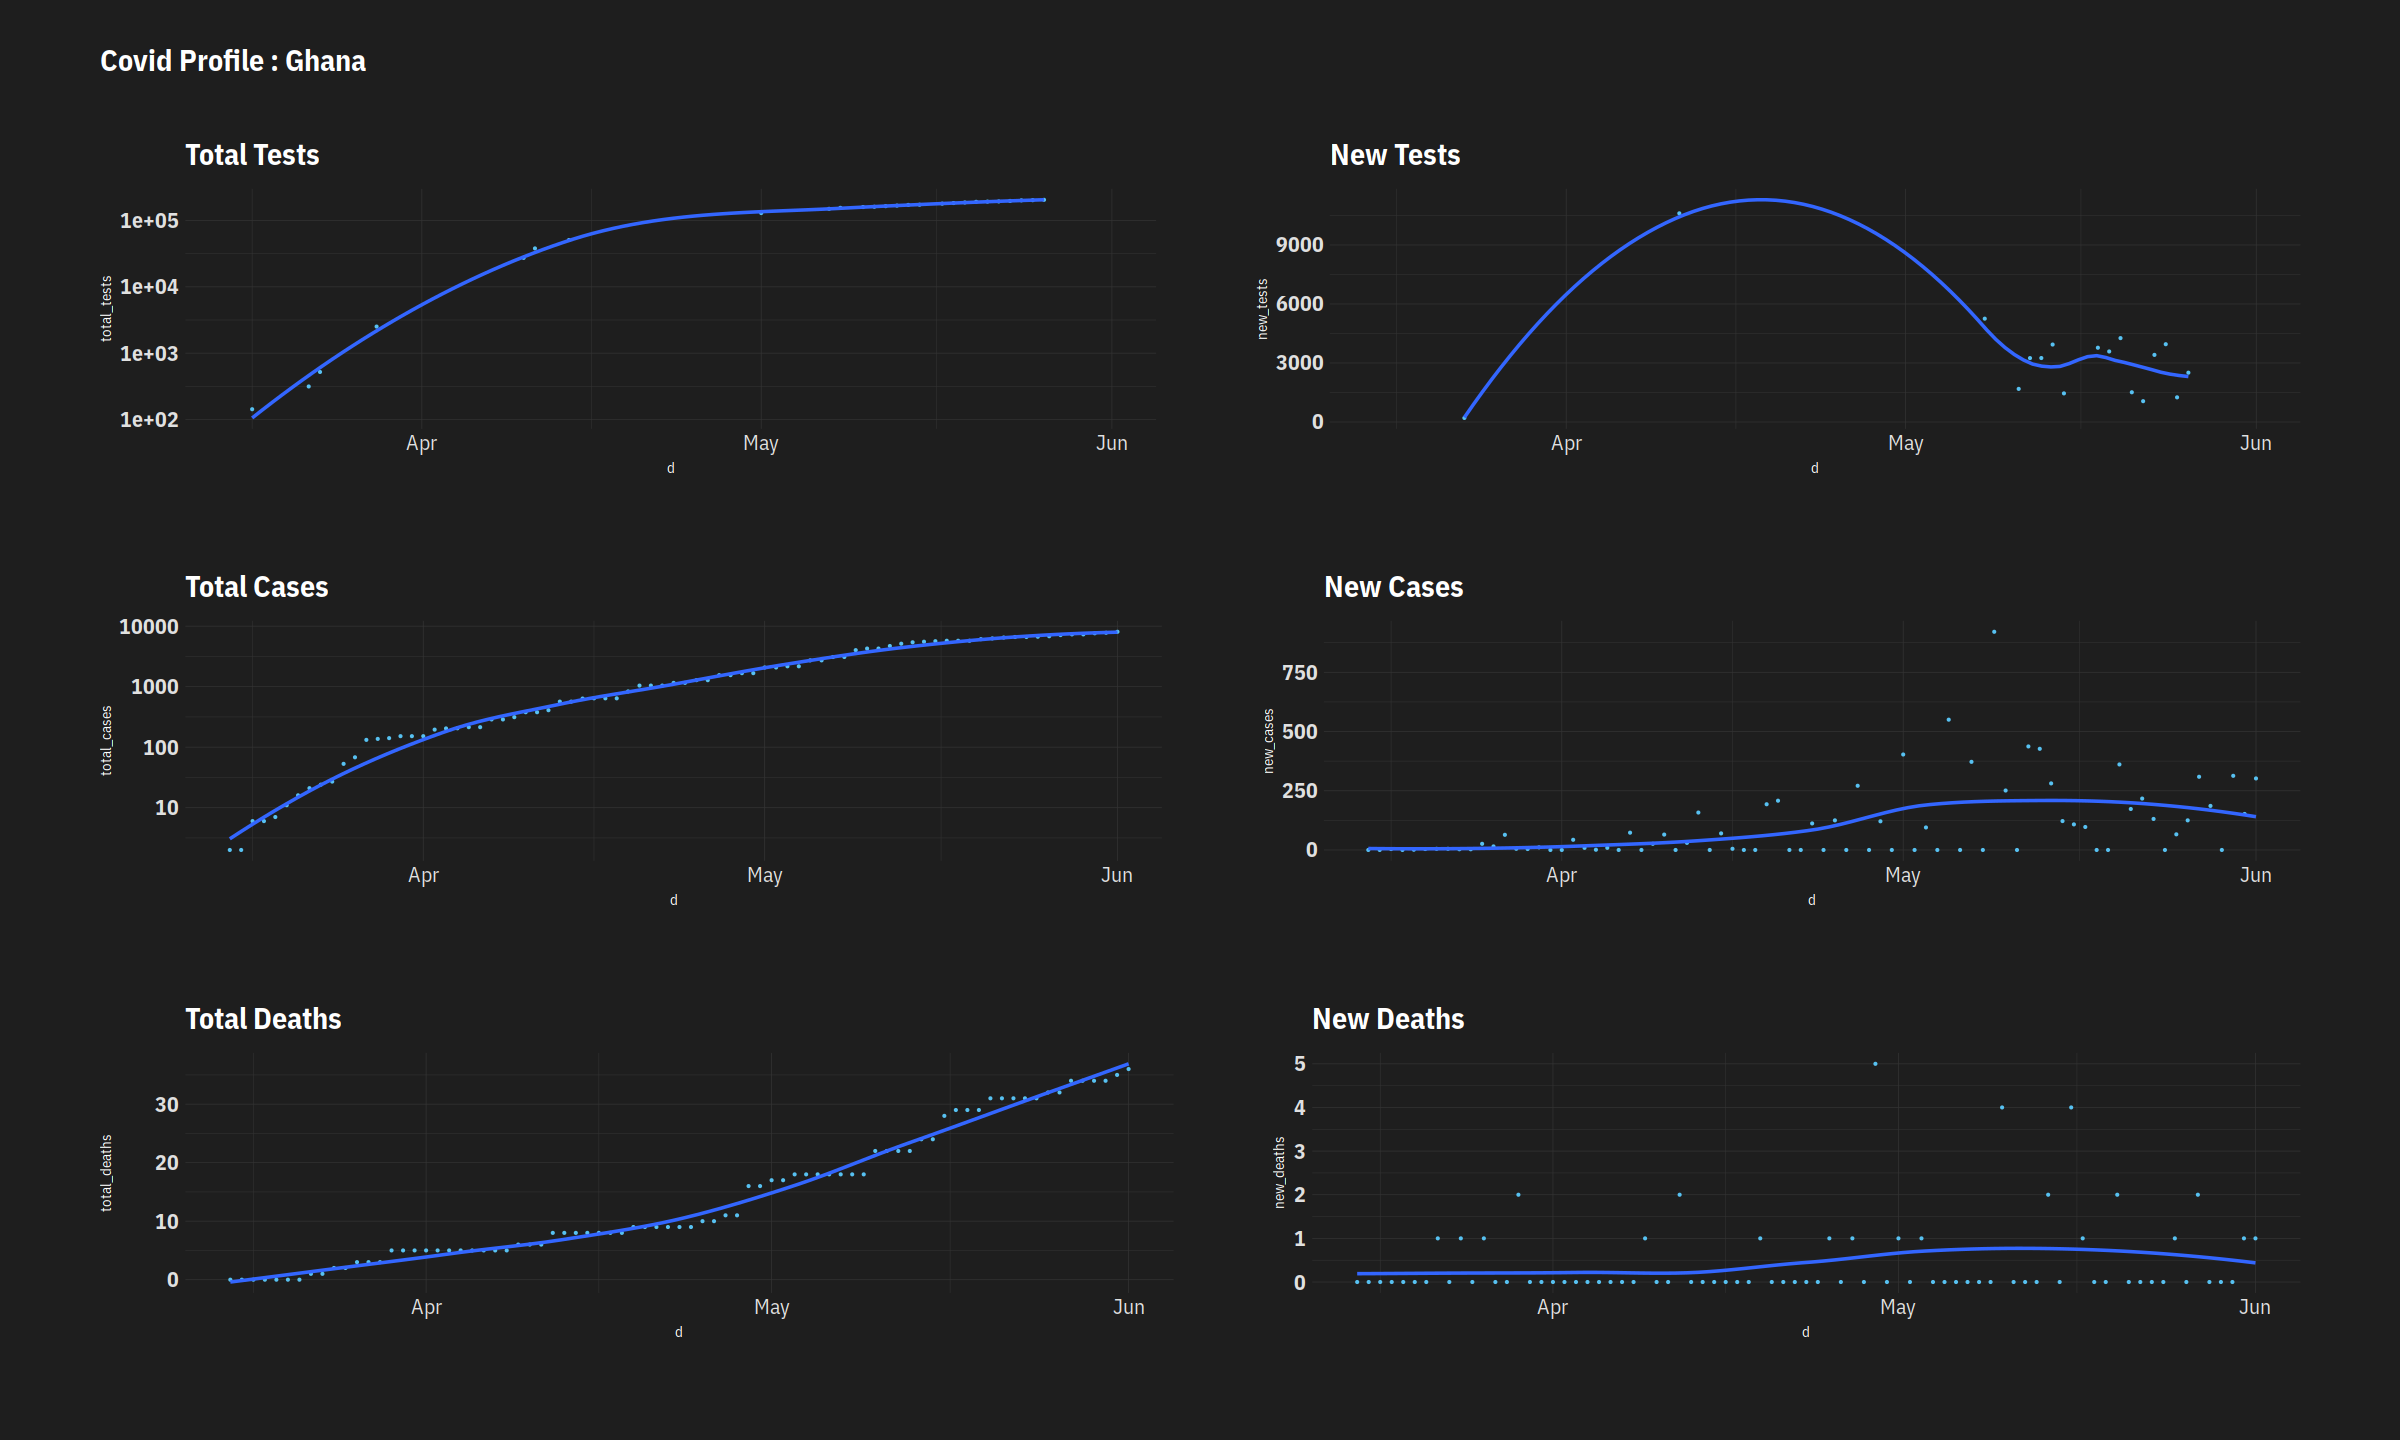

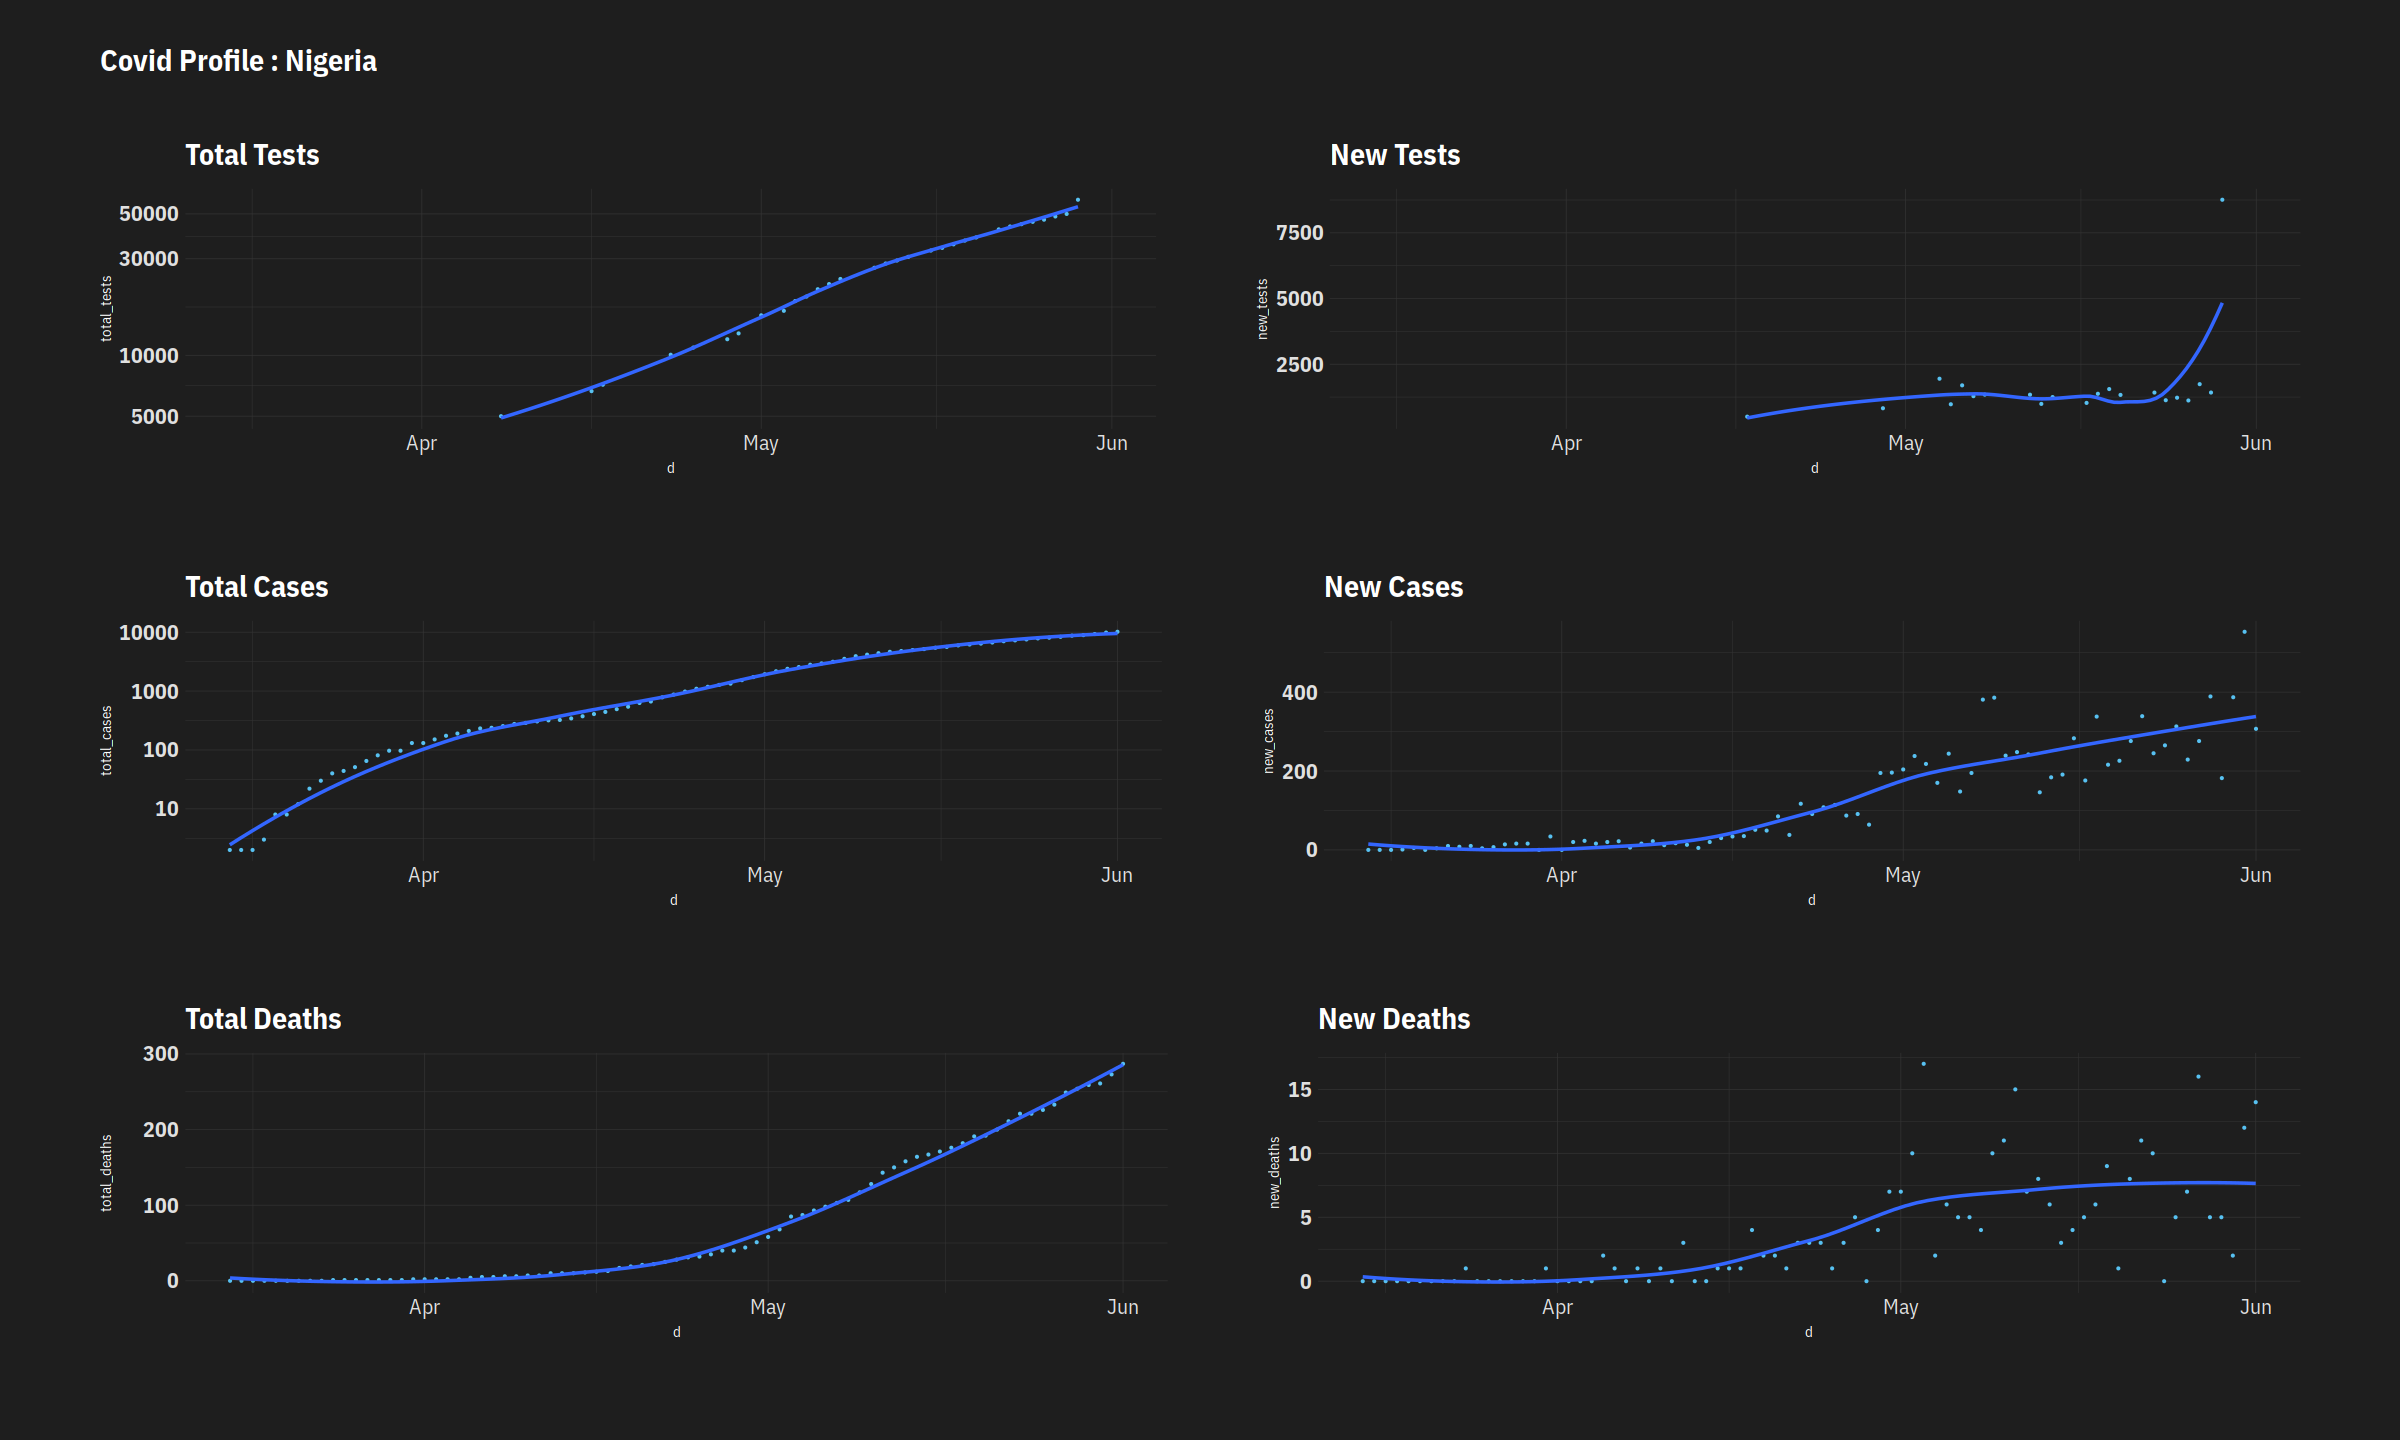

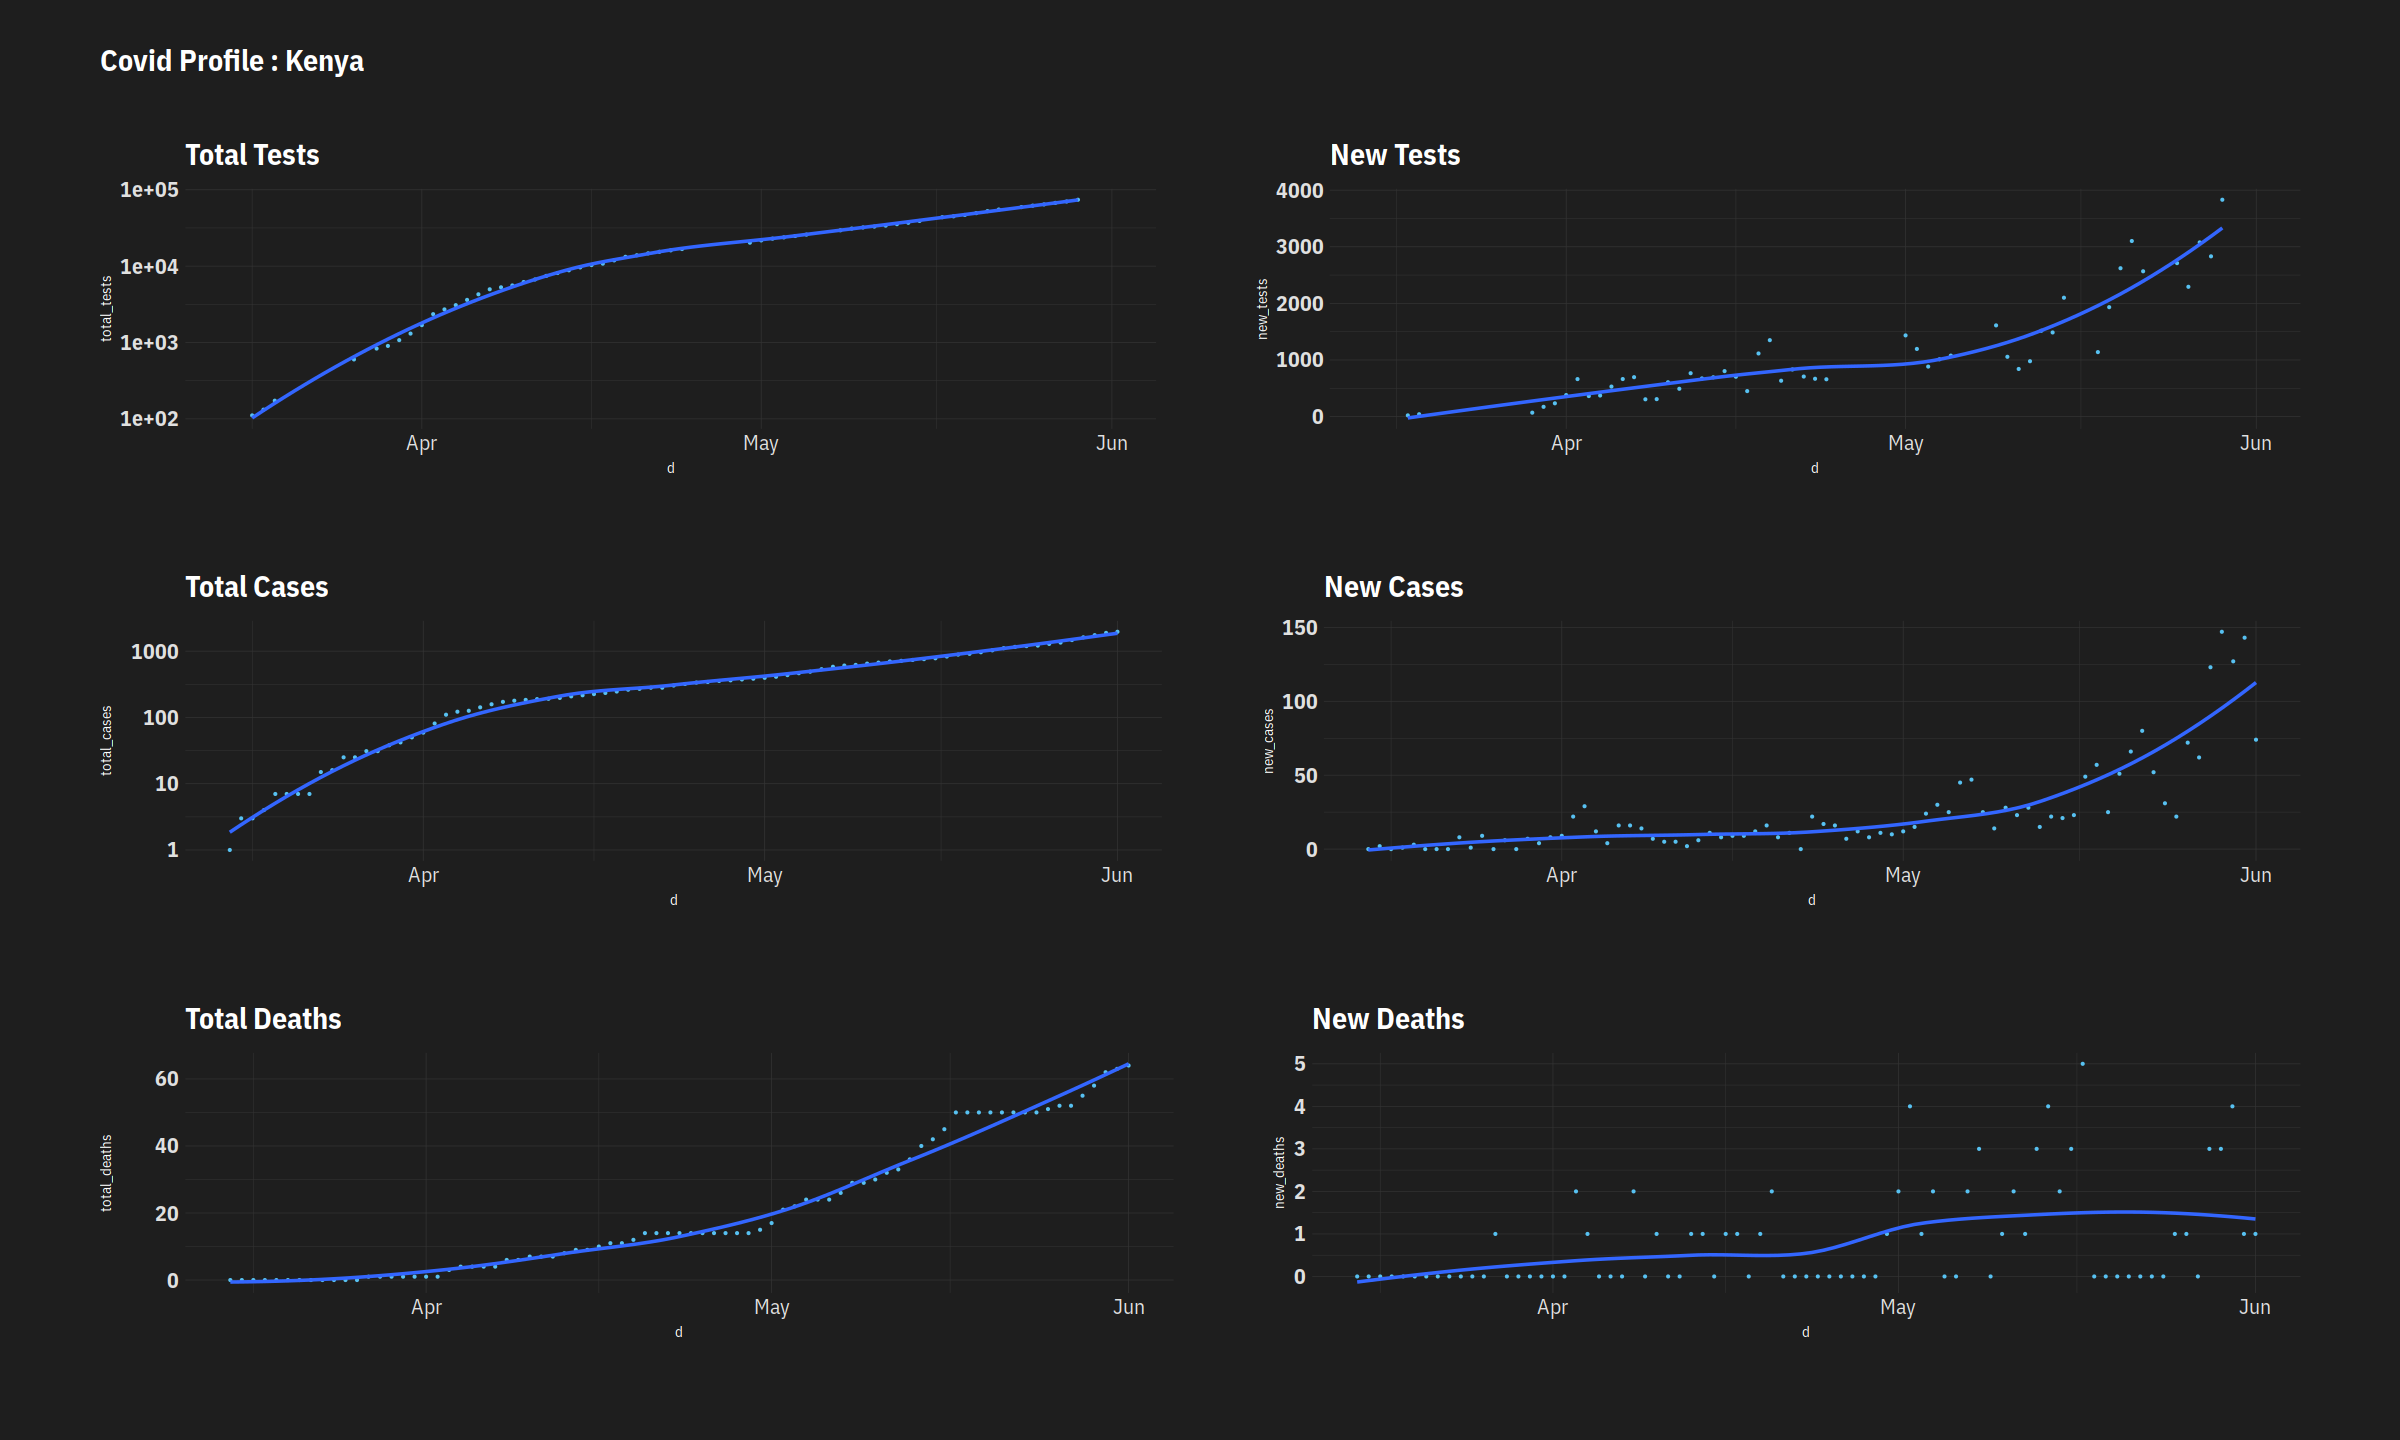

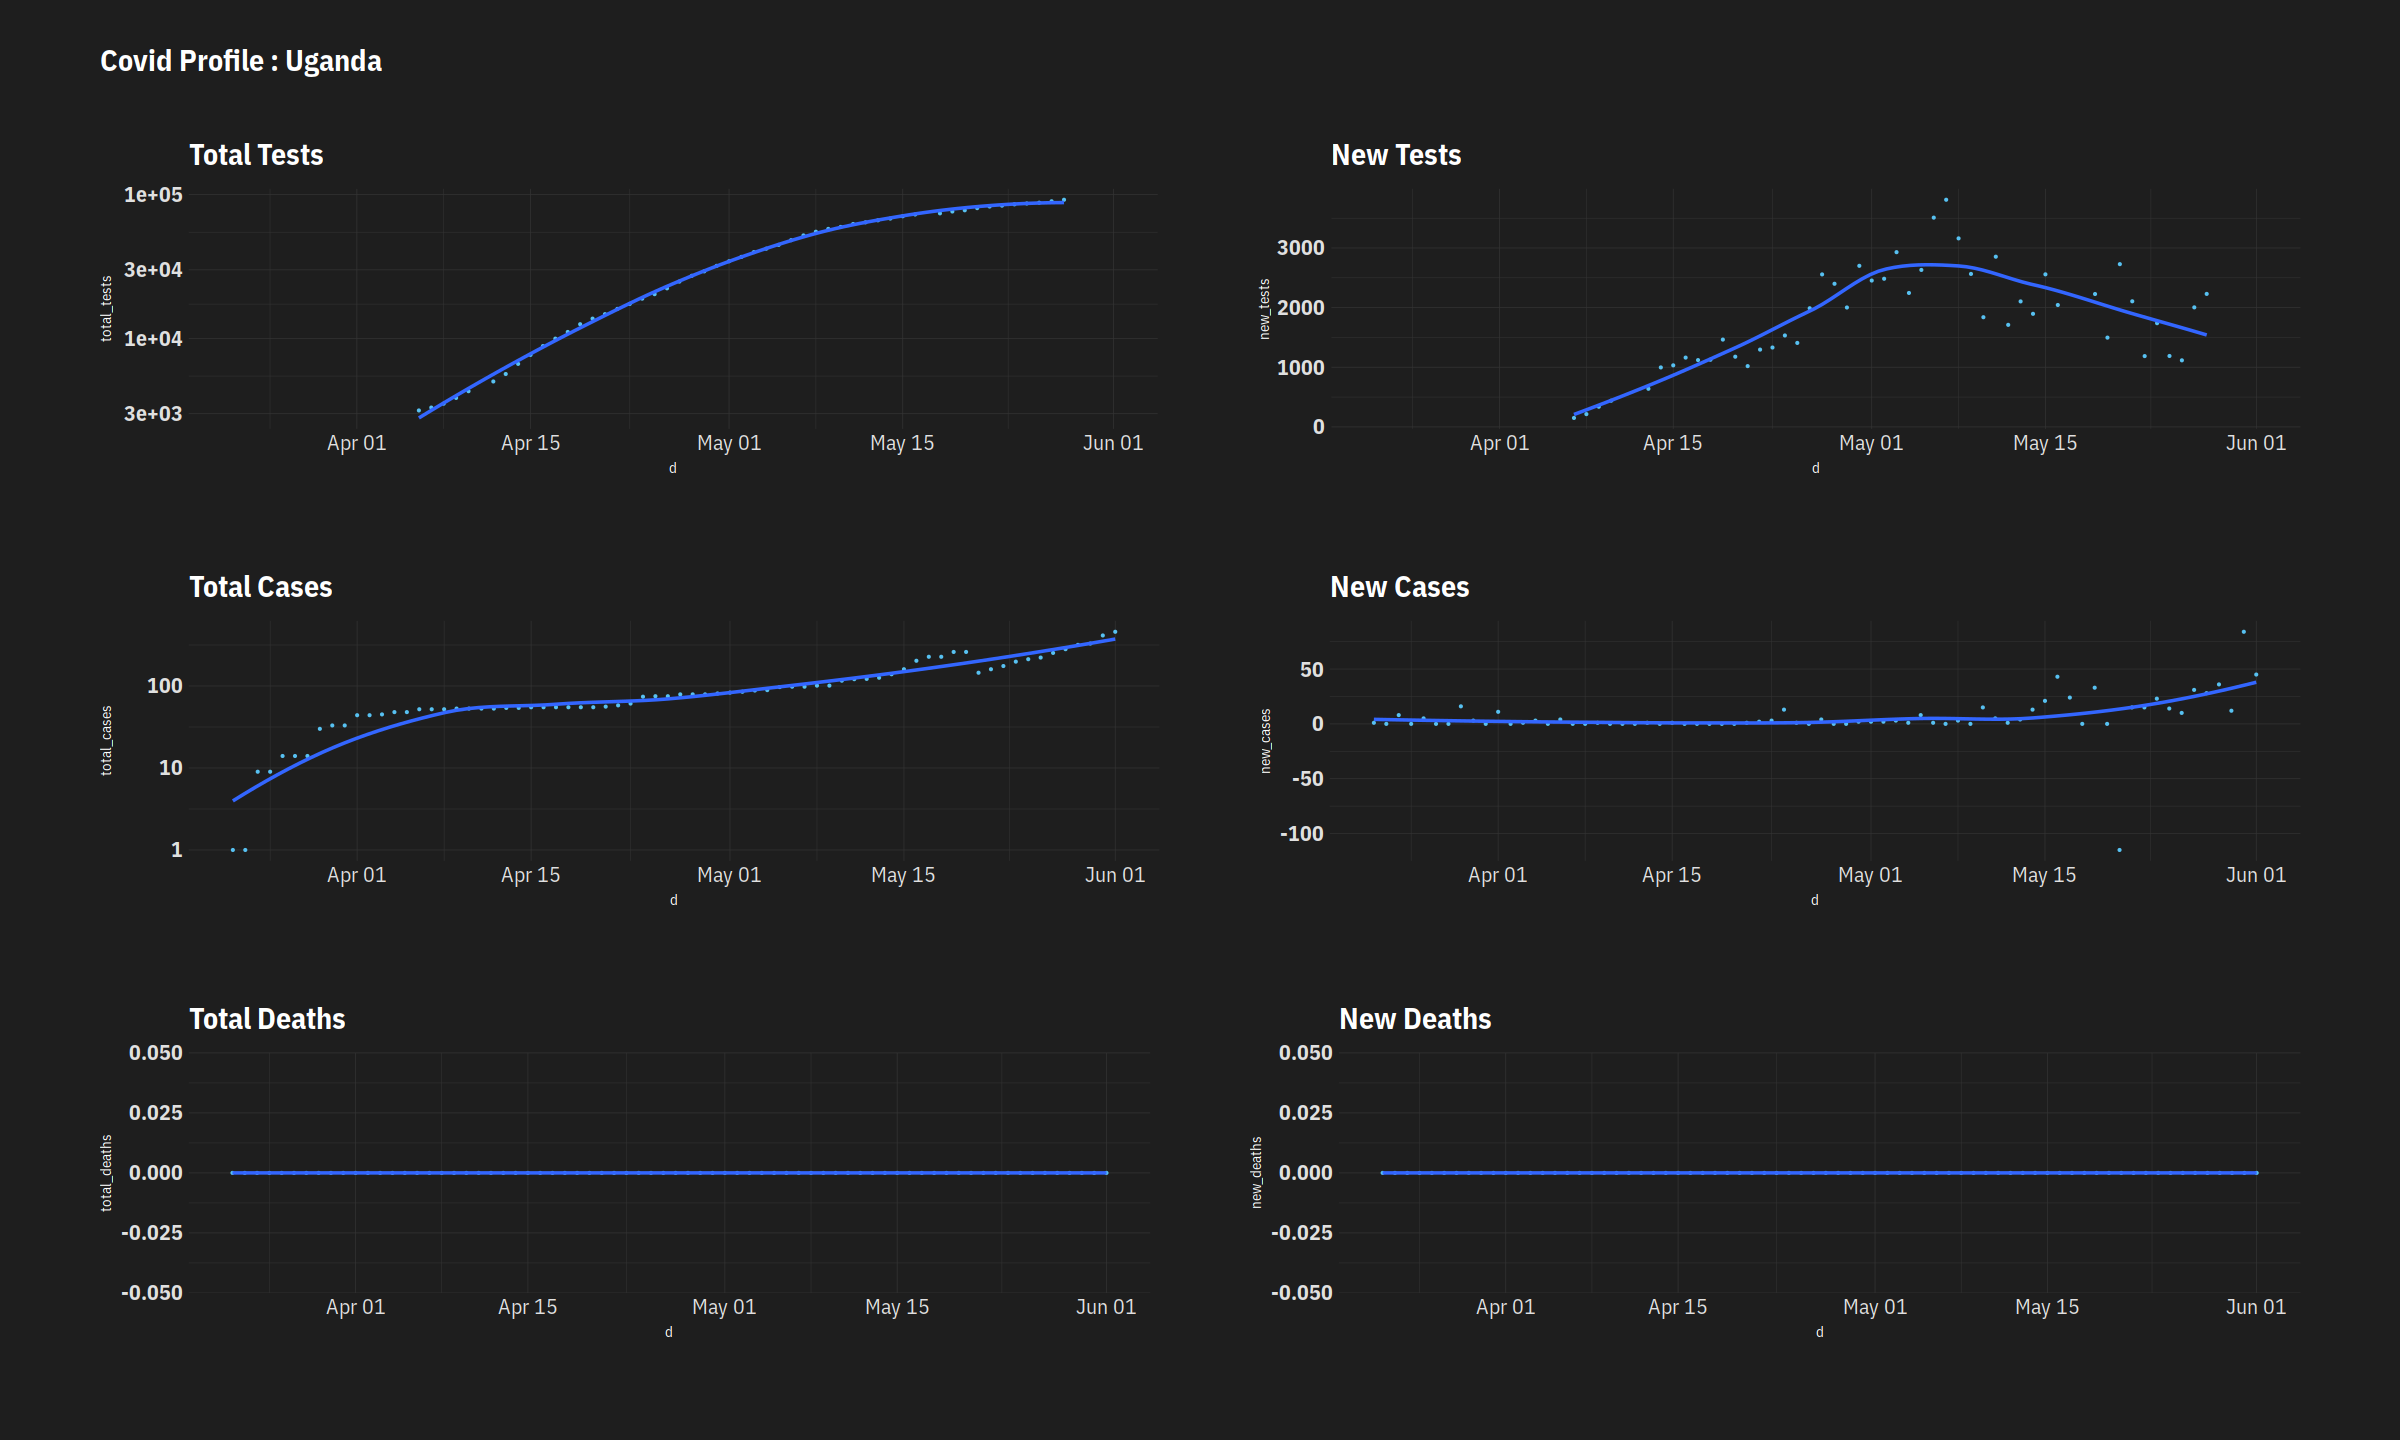

In [29]:
country_plot("Ghana")
country_plot("Nigeria")
country_plot("Kenya")
country_plot("Uganda")

## Eastern Europe

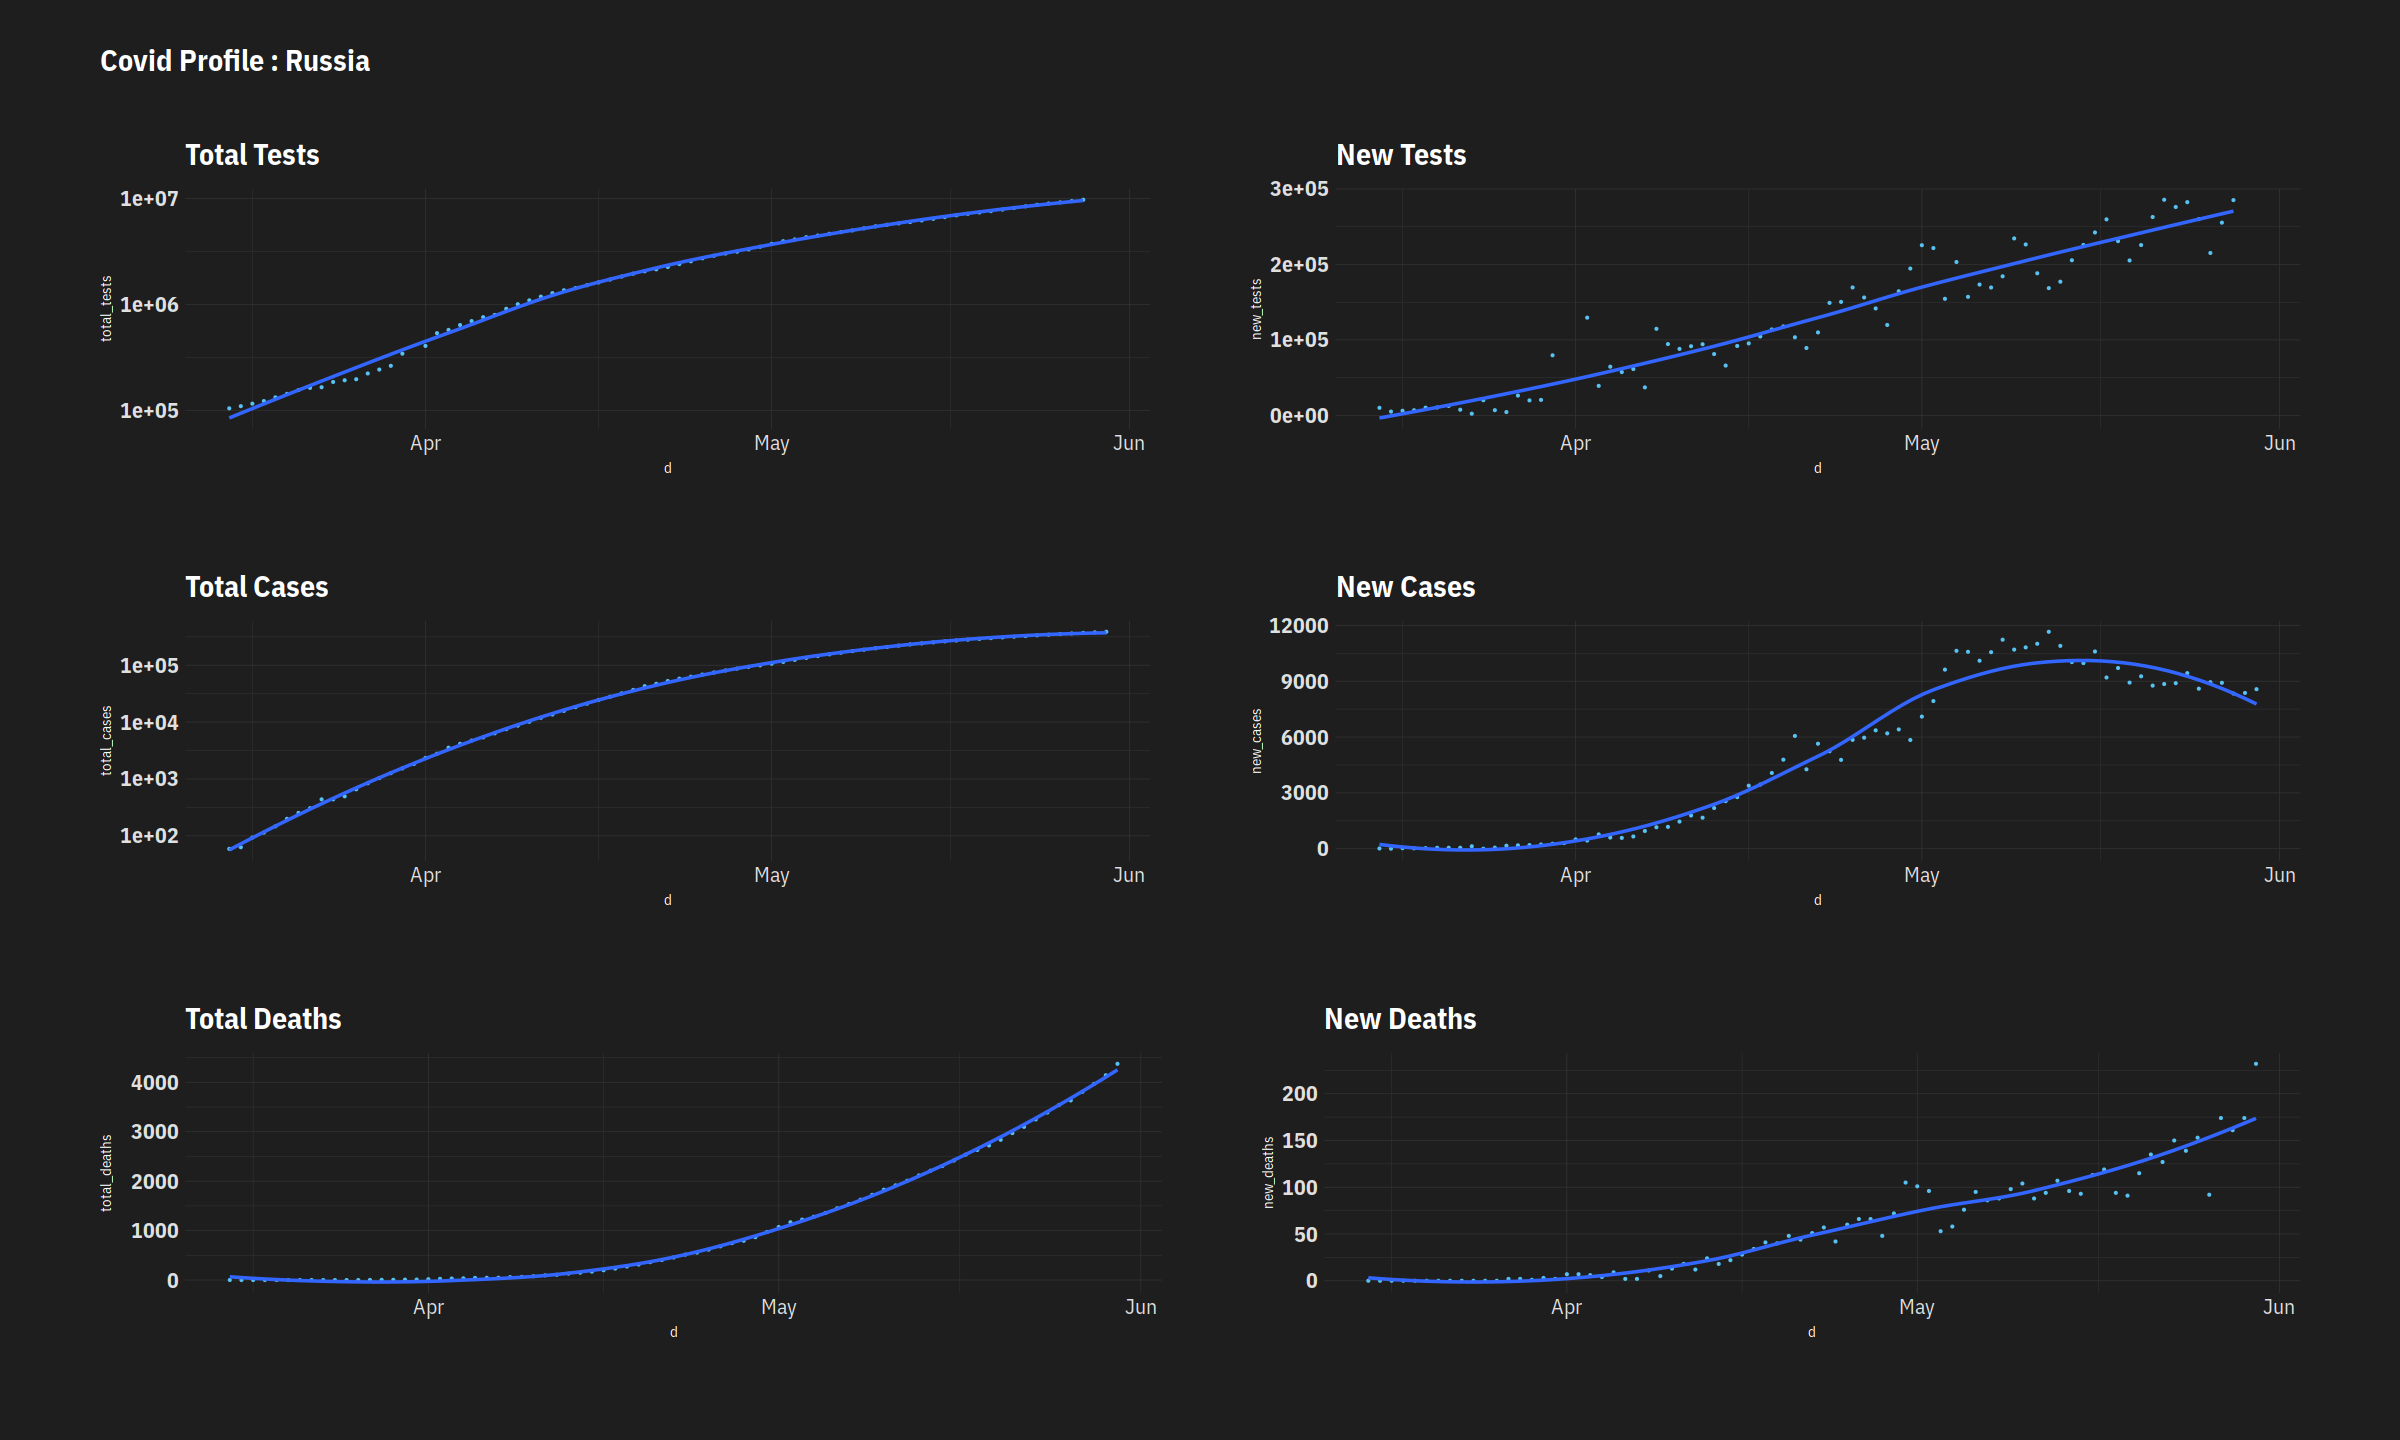

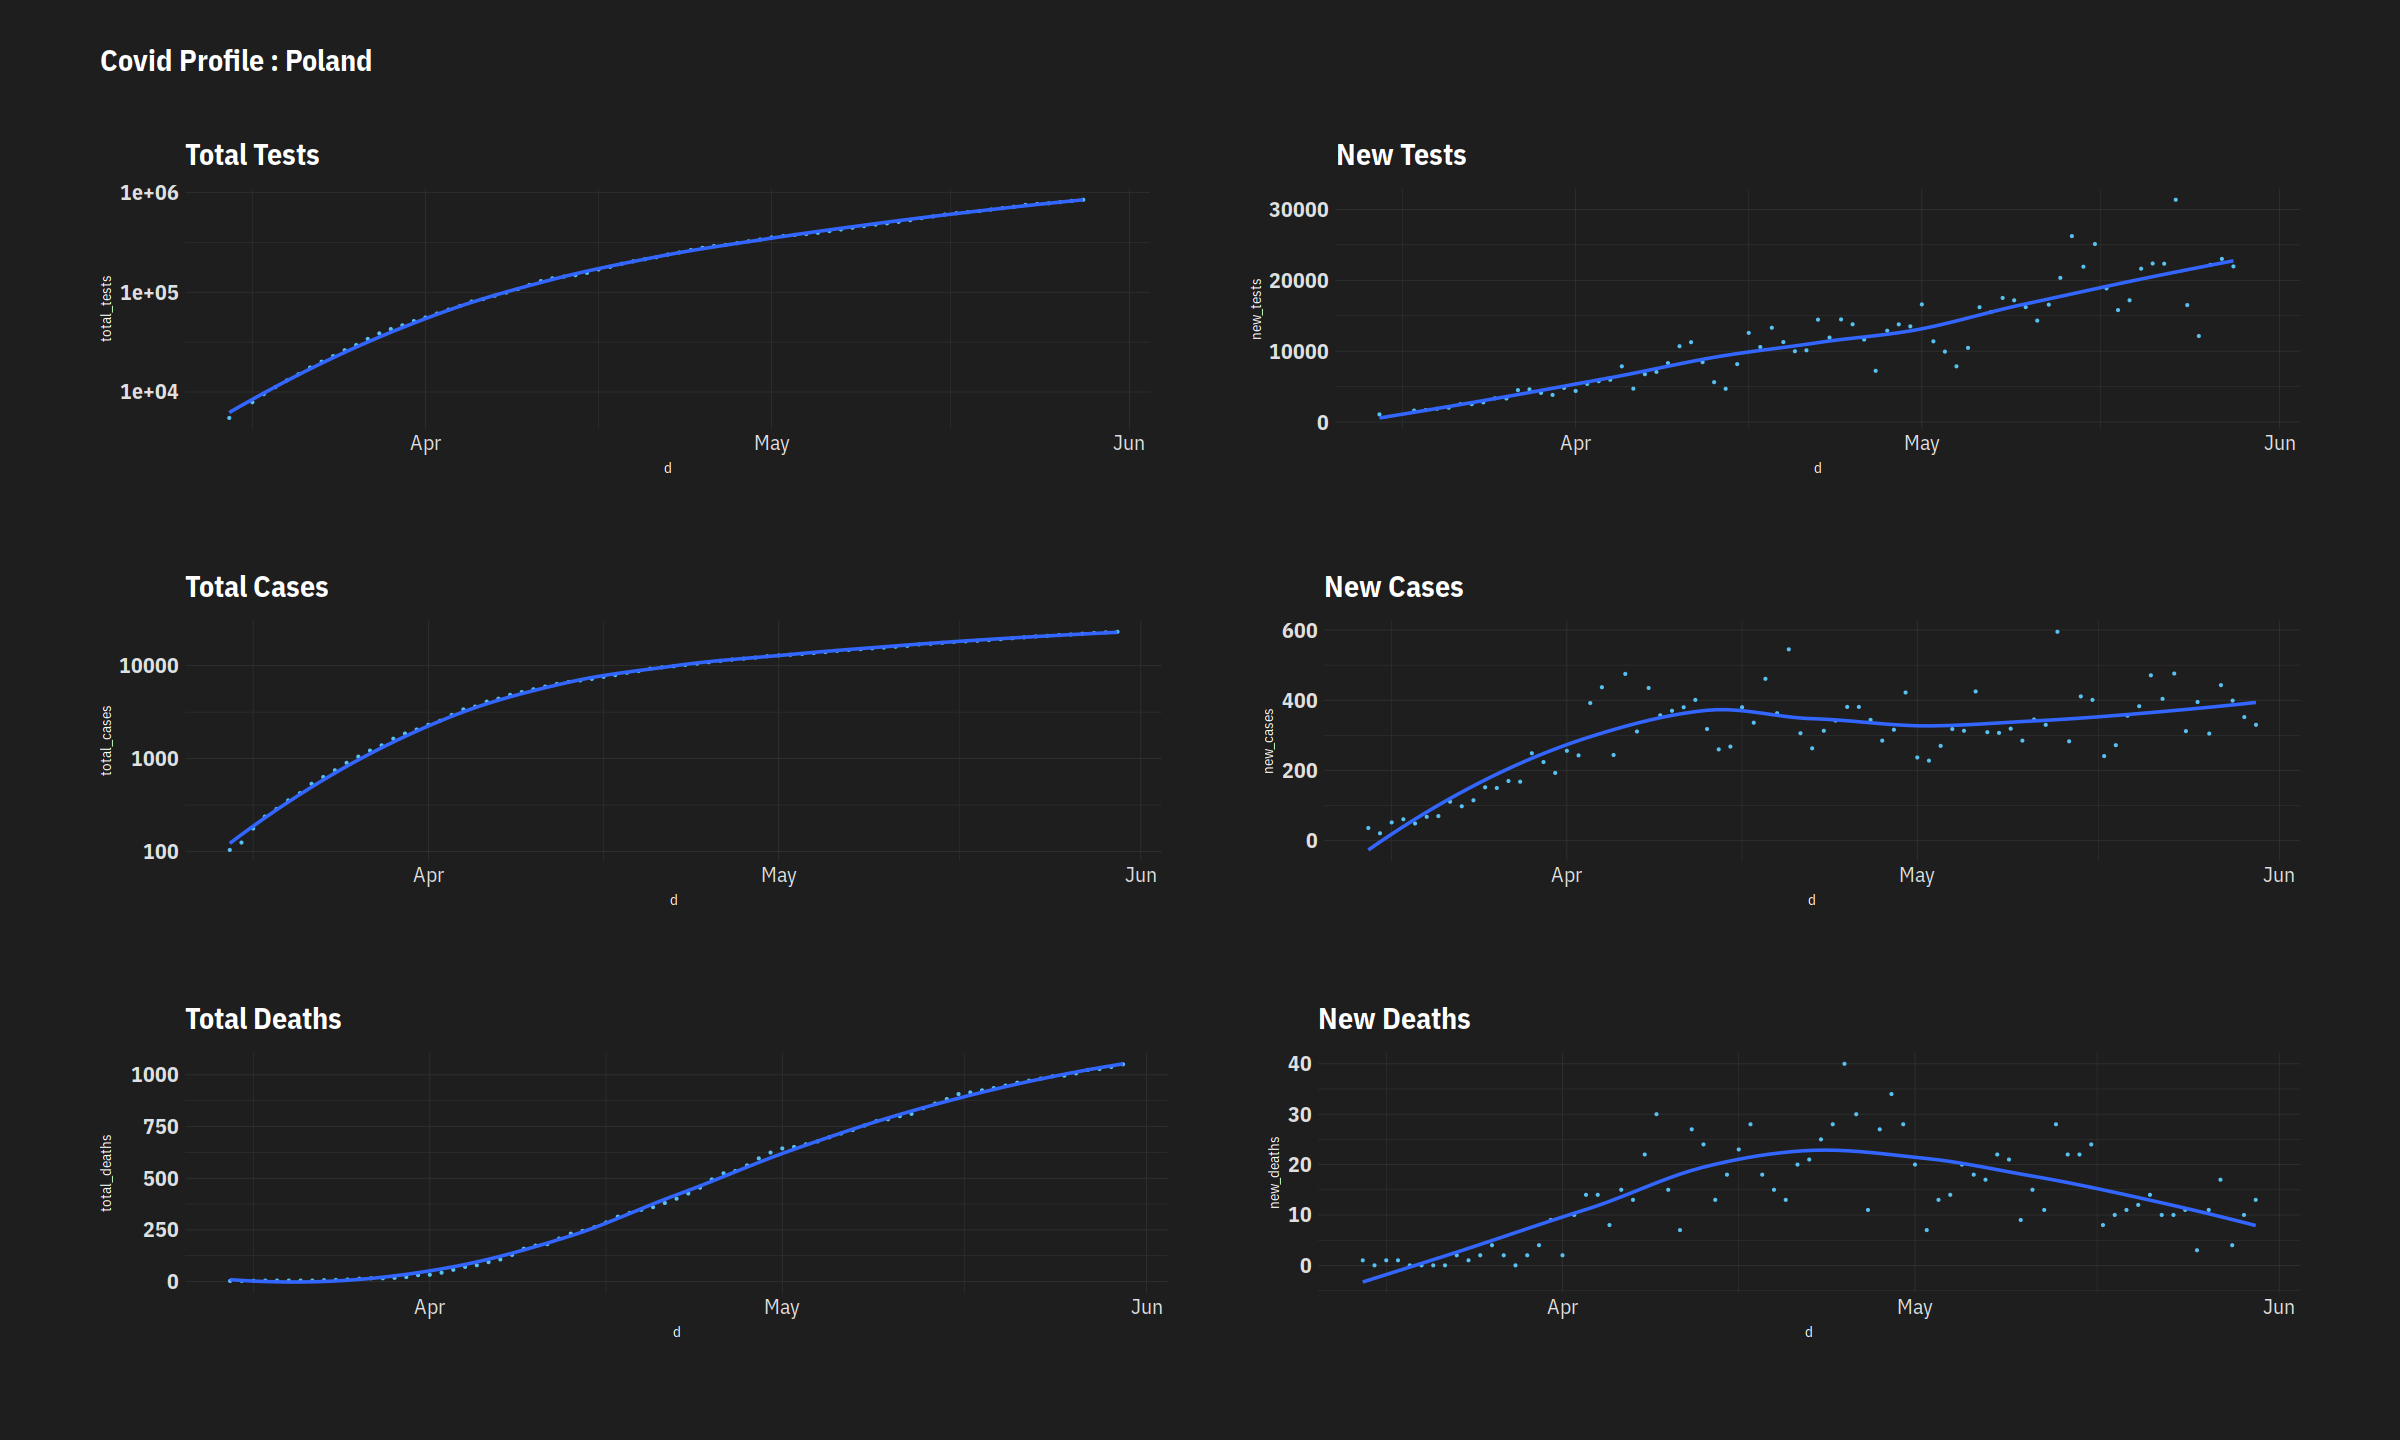

In [25]:
country_plot("Russia")
country_plot("Poland")

# Excess Mortality

In [30]:
exmort_nyt = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/excess-deaths/deaths.csv")
exmort_nyt[, `:=`(
             start_date = ymd(start_date),
             end_date   = ymd(start_date),
             year = as.numeric(year)
           )
           ]
exmort_nyt %>% glimpse

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


Rows: 4,573
Columns: 12
$ country         <chr> "Austria", "Austria", "Austria", "Austria", "Austria"…
$ placename       <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ frequency       <chr> "weekly", "weekly", "weekly", "weekly", "weekly", "we…
$ start_date      <date> 2015-01-05, 2015-01-12, 2015-01-19, 2015-01-26, 2015…
$ end_date        <date> 2015-01-05, 2015-01-12, 2015-01-19, 2015-01-26, 2015…
$ year            <dbl> 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,…
$ month           <int> 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,…
$ week            <int> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ deaths          <int> 1768, 1837, 1792, 1837, 1926, 1992, 2020, 1883, 1846,…
$ expected_deaths <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ excess_deaths   <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ baseline        <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…


In [31]:
exmort_nyt[, .N, by = .(country, placename, frequency)]

country        placename      frequency N  
1  Austria                       weekly    267
2  Belgium                       weekly    216
3  Brazil         Fortaleza      weekly     85
4  Brazil         Manaus         weekly     85
5  Brazil         Recife         weekly     85
6  Brazil         Rio de Janeiro weekly     85
7  Brazil         Sao Paulo      weekly     85
8  Chile                         monthly    52
9  Denmark                       weekly    267
10 Ecuador                       monthly    32
11 Finland                       weekly    166
12 France                        weekly    483
13 Germany                       weekly    215
14 Indonesia      Jakarta        monthly   124
15 Israel                        monthly    63
16 Italy                         monthly     6
17 Netherlands                   weekly    217
18 Norway                        weekly    267
19 Peru                          monthly    52
20 Portugal                      weekly    266
21 Russia         Moscow         monthly    64
22 South Africa                  weekly     66
23 Spain                         weekly    106
24 Sweden                        weekly    267
25 Switzerland                   weekly    217
26 Turkey         Istanbul       weekly     48
27 United Kingdom                weekly    518
28 United States  New York City  weekly    169

In [32]:
wksamp = exmort_nyt[frequency == "weekly" & year == 2020]

In [33]:
eur = exmort_nyt[country %in% c(
    'Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Netherlands', 
    'Norway', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', "Switzerland"
    ) & year == 2020]
eur %>% head

country placename frequency start_date end_date   year month week deaths
1 Austria           weekly    2020-01-06 2020-01-06 2020 1     2    1702  
2 Austria           weekly    2020-01-13 2020-01-13 2020 1     3    1797  
3 Austria           weekly    2020-01-20 2020-01-20 2020 1     4    1777  
4 Austria           weekly    2020-01-27 2020-01-27 2020 2     5    1947  
5 Austria           weekly    2020-02-03 2020-02-03 2020 2     6    1678  
6 Austria           weekly    2020-02-10 2020-02-10 2020 2     7    1720  
  expected_deaths excess_deaths baseline                
1 1857            -155          2015-2019 weekly average
2 1786              11          2015-2019 weekly average
3 1747              30          2015-2019 weekly average
4 1818             129          2015-2019 weekly average
5 1836            -158          2015-2019 weekly average
6 1812             -92          2015-2019 weekly average

In [34]:
eur[is.na(start_date), start_date := ymd(paste0(year, '-', month, "-01"))]
eur[, excess := fifelse(excess_deaths > 0, 1, 0)]

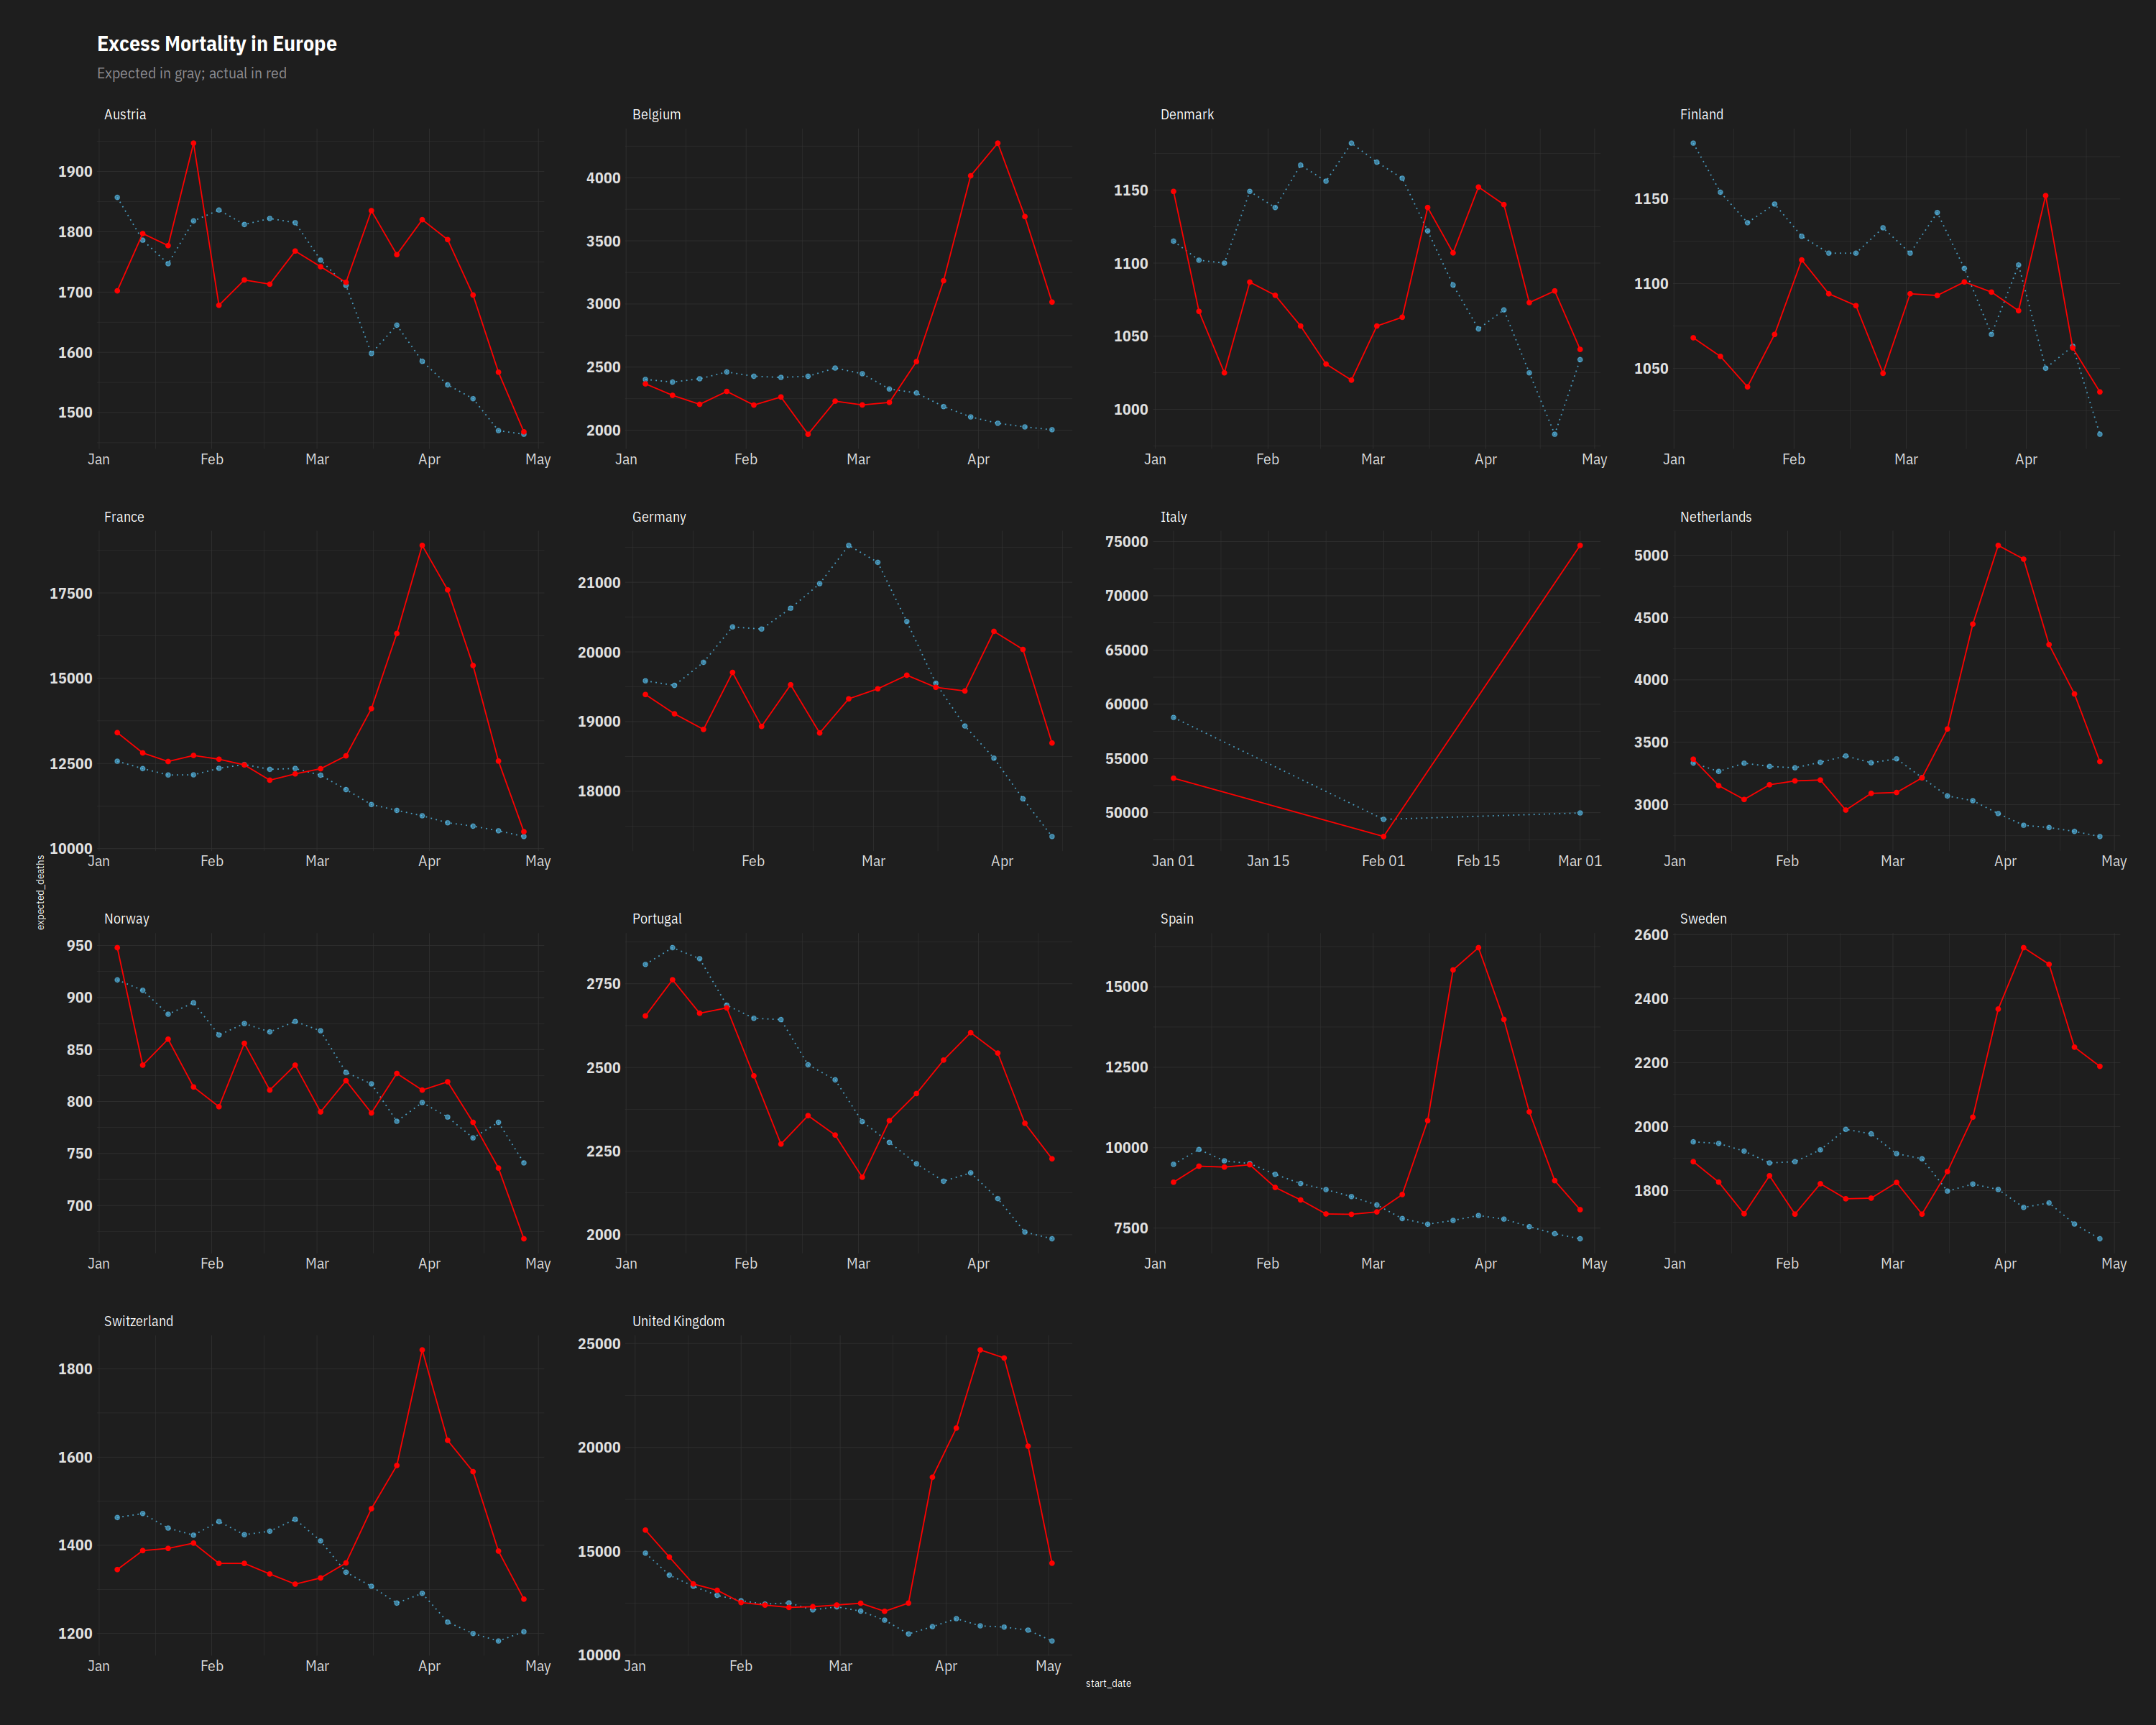

In [35]:
options(repr.plot.width = 25, repr.plot.height=20)
ggplot(eur, aes(x = start_date, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ country, scales = 'free') +
    labs(title = "Excess Mortality in Europe", subtitle = "Expected in gray; actual in red") 